# Imports

In [1]:
import pandas as pd
import pickle
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
from enum import Enum
from torch.nn import functional as F
import time
import logging
import numpy as np
import math
from matplotlib import pyplot as plt

logger = logging.getLogger(__name__)
random.seed(13)

# Utilities

In [2]:
def pytorch_cos_sim(a: torch.Tensor, b: torch.Tensor):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    This function can be used as a faster replacement for 1-scipy.spatial.distance.cdist(a,b)
    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))

In [3]:
def string_sentence(i,qr):
    return qr.loc[i,'Title'] + ' '  + ' '.join(qr.loc[i,'Tags']) + ' '  + qr.loc[i,'Text']

# Model Hyper-Parameters

In [4]:
folder_quora = '/home/ckm/visualqatickets/superuser/Data'
folder = './related/Models'
os.makedirs(folder,exist_ok = True)
BATCH_SIZE = 8
fin_BATCH_SIZE = 32
n_worker = 8
margin = 0.9

#---------
#Note that amp cannot be used without sigmoid
use_amp = True
use_sig = True
#----------

use_sig_eval = False
# eval_BATCH_SIZE = 4 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Creating Dataset and Dataloader

### Loading Data

In [5]:
with open(folder_quora+'/pandas/split.txt','rb') as a:
    train_qr=pickle.load(a)
    dev_qr = pickle.load(a)
    test_qr = pickle.load(a)

In [6]:
with open(folder_quora+'/pairs_related/train_dev_test.txt','rb') as a:
    train_data=pickle.load(a)
    train_score = pickle.load(a)
    dev_data = pickle.load(a)
    dev_score = pickle.load(a)
    test_data = pickle.load(a)
    test_score = pickle.load(a)

In [7]:
with open(folder_quora+'/pairs_related/data_pos_neg.txt','rb') as a:
    train_data_pos = pickle.load(a)
    train_data_neg = pickle.load(a)
    dev_data_pos = pickle.load(a)
    dev_data_neg = pickle.load(a)
    test_data_pos = pickle.load(a)
    test_data_neg = pickle.load(a)

In [8]:
qr = pd.concat([train_qr,dev_qr,test_qr])

### Creating Dataset 

In [9]:
from transformers import BertTokenizerFast, BertConfig,BertModel
config = BertConfig()
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [10]:
class custom_dataset(Dataset):
    def __init__(self,qr,qr_idx,label,transform = None):
        self.qr = qr
        self.qr_idx = qr_idx
        self.label = label
        self.transform = transform
    
    def __getitem__(self,idx):
        id1 = self.qr_idx[idx][0]
        id2 = self.qr_idx[idx][1]

        sample = dict()

        t1 = self.qr.loc[id1,'Title'] + ' ' + ' '.join(self.qr.loc[id1,'Tags']) + ' ' + self.qr.loc[id1,'Text']
        t2 = self.qr.loc[id2,'Title']+ ' ' + ' '.join(self.qr.loc[id2,'Tags']) + ' ' + self.qr.loc[id2,'Text'] 
        indexed_t1 = tokenizer.encode(t1,max_length = 350,truncation = True)
        indexed_t2 = tokenizer.encode(t2,max_length = 350,truncation = True)

        while(len(indexed_t1)<350):
            indexed_t1.append(0)
        while(len(indexed_t2)<350):
            indexed_t2.append(0)

        ten_t1 = torch.tensor(indexed_t1)
        ten_t2 = torch.tensor(indexed_t2)

        # print(ten_t1)
        # print(ten_t2)

        label_cos = self.label[idx]
        if(label_cos==0.0):
            label_cos = -1.0

        try:
            sample["label"] = self.label[idx]
            sample["token"] = [ten_t1,ten_t2] # torch.Size([batch_size, 512])
            sample["label_cos"] = label_cos
        except Exception as e:
            print(e)
        
        return sample

    def __len__(self):
        return len(self.label)

In [11]:
class pos_dataset(Dataset):
    def __init__(self,qr,qr_idx):
        self.qr = qr
        self.qr_idx = qr_idx
    
    def __getitem__(self,idx):
        id1 = self.qr_idx[idx][0]
        id2 = self.qr_idx[idx][1]

        sample = dict()

        t1 = '[CLS]' + self.qr.loc[id1,'Title'] + ' ' + ' '.join(self.qr.loc[id1,'Tags']) + ' ' + self.qr.loc[id1,'Text'] + '[SEP]'
        t2 = '[CLS]' + self.qr.loc[id2,'Title']+ ' ' + ' '.join(self.qr.loc[id2,'Tags']) + ' ' + self.qr.loc[id2,'Text'] + '[SEP]'
        indexed_t1 = tokenizer.encode(t1,max_length = 512,truncation = True)
        indexed_t2 = tokenizer.encode(t2,max_length = 512,truncation = True)

        while(len(indexed_t1)<512):
            indexed_t1.append(0)
        while(len(indexed_t2)<512):
            indexed_t2.append(0)

        ten_t1 = torch.tensor(indexed_t1)[:512]
        ten_t2 = torch.tensor(indexed_t2)[:512]

    

        try:
            sample["token"] = [ten_t1,ten_t2] # torch.Size([batch_size, 512])
        except Exception as e:
            print(e)
        
        return sample

    def __len__(self):
        return len(self.qr_idx)

In [12]:
class ConcatDataset(Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

## Train, dev and test dataloader

In [13]:
train_dataset = custom_dataset(train_qr,
                               train_data,
                               train_score)

# train_MNR_dataset = pos_dataset(train_qr,
#                                 train_data_pos)

# fin_train_dataset = ConcatDataset(train_dataset,train_MNR_dataset)

In [14]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    shuffle = True,
    drop_last = True
    )

In [15]:
dev_dataset = custom_dataset(pd.concat([train_qr,dev_qr]),
                             dev_data,
                             dev_score)

In [16]:
dev_loader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True
    )

In [17]:
test_dataset = custom_dataset(pd.concat([train_qr,test_qr]),
                              test_data,
                              test_score)

In [18]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True
    )

# Model

## Loading Model 

In [19]:
from torchvision import models

bert = BertModel.from_pretrained('bert-base-uncased')
bert = bert.to(device)
for param in bert.parameters():
    param.requires_grad = True

for param in bert.embeddings.parameters():
    param.requires_grad = False

for param in bert.encoder.layer[0].parameters():
    param.requires_grad = False

## Model Class

In [20]:
class bertmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = bert
        self.fc = nn.Linear(768,512)
    
    def forward(self,X1):
        #Taking average embeddings of all the words
        # bert_out = torch.mean(self.bert(X1).last_hidden_state,dim=1) #[BATCH_SIZE,768] 
        # out = self.fc(bert_out)

        # Taking only CLS token
        out = self.bert(X1).last_hidden_state[:,0,:]
        # print(out.shape)
        return out

In [21]:
model = bertmodel().to(device)

# Losses

## Multiple Negative Ranking loss

In [22]:
class negrankloss():
    def __init__(self,scale: float = 20.0):
        # self.cosine_sim = nn.CosineSimilarity()
        self.scale = scale
        self.cross_entropy = nn.CrossEntropyLoss()

    def cal_loss(self,emb1: torch.Tensor,emb2: torch.Tensor):
        scores  = pytorch_cos_sim(emb1,emb2) *self.scale
        # print(f'The scores of cosine similarity for MNRloss is {scores}')
        labels = torch.tensor(range(len(scores)), dtype=torch.long, device=scores.device)
        loss = self.cross_entropy(scores, labels)
        return loss

In [23]:
MNRloss = negrankloss()

## Online Constrantive Loss


In [24]:
class SiameseDistanceMetric(Enum):
    """
    The metric for the contrastive loss
    """
    EUCLIDEAN = lambda x, y: F.pairwise_distance(x, y, p=2)
    MANHATTAN = lambda x, y: F.pairwise_distance(x, y, p=1)
    COSINE_DISTANCE = lambda x, y: 1-F.cosine_similarity(x, y)


In [25]:
class OnlineConstrantiveLoss():
    def __init__(self,distance_metric=SiameseDistanceMetric.COSINE_DISTANCE,margin: float = 0.8):
        self.distance_metric = distance_metric
        self.margin = margin

    def cal_loss(self,emb1,emb2,labels,size_average=False):
        distance_matrix = self.distance_metric(emb1,emb2)
        # print(f'distance matrix of OCloss is {distance_matrix}')
        negs = distance_matrix[labels == 0]
        poss = distance_matrix[labels == 1]
        # print(f'positive and negatives are {poss} and {negs}')

        # select hard positive and hard negative pairs
        negative_pairs = negs[negs < (poss.max() if len(poss) > 1 else negs.mean())]
        positive_pairs = poss[poss > (negs.min() if len(negs) > 1 else poss.mean())]

        # print(f'positive and negative pairs are {positive_pairs} and {negative_pairs}')

        positive_loss = positive_pairs.pow(2).sum()
        negative_loss = F.relu(self.margin - negative_pairs).pow(2).sum()
        # print(f'positive loss is {positive_loss} and negative loss is {negative_loss}')
        loss = positive_loss + negative_loss
        return loss
    

In [26]:
OCloss = OnlineConstrantiveLoss(margin = margin)

## Cross Entropy Loss

In [27]:
class crossentropy():
    def __init__(self):
        self.cross_entropy = nn.BCELoss()
        self.cos_sim =  nn.CosineSimilarity(dim=1,eps=1e-6)
        self.sig = nn.Sigmoid()
        self.BCE_with_sig = nn.BCEWithLogitsLoss()
    
    def cal_loss(self,emb1:torch.Tensor,emb2:torch.Tensor,label:torch.Tensor):
        sim = (self.cos_sim(emb1,emb2))

        if(use_sig == True):
            loss = self.BCE_with_sig(sim,label)
        else:
            sim[sim<0] = 0
            loss = self.cross_entropy(sim,label)
        return loss

In [28]:
BCEloss = crossentropy()

## Cosine Similarity

In [29]:
class cos_sim():
    def __init__(self):
        self.cossim = nn.CosineEmbeddingLoss()

    def cal_loss(self,emb1,emb2,target):
        loss = self.cossim(emb1,emb2,target)
        return loss

In [30]:
Cosloss = cos_sim()

# Evaluators: AUC(0.05) and Binary accuracy

In [31]:
import sklearn.metrics as skm

In [32]:
class AUC():
    def __init__(self,max_fpr:float = 0.05):
        self.max_fpr = 0.05
        self.cos_sim =  nn.CosineSimilarity(dim=1,eps=1e-6)
        self.sig = nn.Sigmoid()

    def cal(self,model:bertmodel,loader:DataLoader):
        y_pred = []
        y_true = []
        y_pred_sig = []
        start = time.time()
        model.eval()
        for i,batch in enumerate(loader):
            with torch.no_grad():
                label = batch["label"]
                label = label.float()
                token = batch["token"]

                token[0],token[1] = token[0].to(device), token[1].to(device)
                label = label.to(device)
            
                # compute the model output
                yhat1 = model(token[0])
                yhat2 = model(token[1])

                if(i%1000==0):
                    print(f'    {i} iterations have been done in {time.time()-start} seconds')

                sim = (self.cos_sim(yhat1,yhat2))
                a=self.sig(sim)
                a[a>=0.5] = 1
                a[a<0.5] = 0

                y_pred_sig.append(a.cpu().numpy())
                y_pred.append(sim.cpu().numpy())
                y_true.append(label.cpu().numpy())

                del  label, token,yhat1,yhat2,sim,a 
        
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()
        y_pred_sig = np.array(y_pred_sig).flatten()
        Bin_score = skm.accuracy_score(y_true,y_pred_sig) 
        AUC_score = skm.roc_auc_score(y_true,y_pred,max_fpr = self.max_fpr)
        conf_matrix = skm.confusion_matrix(y_true,y_pred_sig)
        plt.hist(y_pred,bins='auto')
        plt.show()
        return AUC_score,Bin_score,conf_matrix


In [33]:
AUC_evaluator = AUC()

# Calculating loss and executing

In [34]:
save_dir = folder + '/model_state_dict'
os.makedirs(save_dir,exist_ok = True)

In [35]:
from torch.optim import Adam
from torch.nn import BCELoss
import time
import copy
from transformers import get_linear_schedule_with_warmup

def train_model(train_loader, model,num_epochs):
    model.train()

    since = time.time()

    optimizer = Adam(model.parameters(), lr=4e-6)
    # optimizer = Adam([{'params': model.res50.parameters(), 'lr': 4e-6},
    #                   {'params': model.bert.parameters(), 'lr': 4e-6},
    #                   {'params': model.bertl_text.parameters(), 'lr': 4e-6},
    #                   {'params': model.bertl_attribute.parameters(), 'lr': 4e-6},
    #                   {'params': model.bridge_seven_conv.parameters()},
    #                   {'params': model.bridge_one_conv.parameters()},
    #                   {'params': model.flatten.parameters()},
    #                   {'params': model.linear_2d.parameters()},
    #                   {'params': model.soft_2d.parameters()},
    #                   {'params': model.final_2d.parameters()},
    #                   {'params': model.fc.parameters()},
    #                   {'params': model.fc2.parameters()},
    #                   {'params': model.co_attention.parameters()}
    #                   ], lr=4e-4, weight_decay=1e-2)
    train_steps = num_epochs
    
    best_acc = 0.0

    acc_steps = fin_BATCH_SIZE/BATCH_SIZE

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    cos_sim = nn.CosineSimilarity(dim=1,eps=1e-6)
    sig = nn.Sigmoid()

    #Clipping grads
    torch.nn.utils.clip_grad_value_(model.parameters(),-1)

    # torch.autograd.set_detect_anomaly(True)

    # Evaluating on dev loader
    # print('Running dev_evaluator')
    # a,b,c = AUC_evaluator.cal(model,dev_loader)
    # print(f'AUC score is {a}  while binary score is {b} and the confusion matrix is {c} on dev loader before training')

    for epoch in range(num_epochs):
        # enumerate mini batches
        # avg_loss = 0
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        running_OCloss = 0.0
        running_MNRloss = 0.0
        running_BCEloss = 0.0
        running_Cosloss = 0.0

        model.zero_grad()

        y_pred = []
        y_true = []
        y_pred_sig = []

        for i, batch in enumerate(train_loader):
            model.train()

            with torch.cuda.amp.autocast(enabled=use_amp):
                
                if(i%100000 == 0 and i!=0 ):
                    print('Running dev_evaluator for 2000 samples i.e. 1000 iterations. Time taken: 5 min')
                    a,b,c = AUC_evaluator.cal(model,dev_loader)
                    print(f'AUC score is {a}  while binary score is {b} and the confusion matrix is {c} on dev loader after {i} iterations and {epoch+1} epoch')
                    torch.save(model.state_dict(), save_dir+'/bert_cos.bin')
                    print(f'Model is saved after {i} iterations ')
                    model.train()
        
                label = batch["label"]
                label = label.float()
                token = batch["token"]
                label_cos = batch['label_cos']

                # pos_token = batch[1]['token']

                token[0],token[1] = token[0].to(device), token[1].to(device)
                # pos_token[0],pos_token[1] = pos_token[0].to(device), pos_token[1].to(device)
                label = label.to(device)
                label_cos = label_cos.to(device)
                
                # compute the model output
                yhat1= model(token[0])
                yhat2 = model(token[1])

                sim = (cos_sim(yhat1,yhat2))
                a=sig(sim)
                a[a>=0.5] = 1
                a[a<0.5] = 0

                y_pred_sig.append(a.detach().cpu().numpy())
                y_pred.append(sim.detach().cpu().numpy())
                y_true.append(label.detach().cpu().numpy())

                # yhat1_pos = model(pos_token[0])
                # yhat2_pos = model(pos_token[1])
                
                BCEloss_val = BCEloss.cal_loss(yhat1,yhat2,label)
                running_BCEloss += BCEloss_val.item()*BATCH_SIZE
                BCEloss_val = BCEloss_val/acc_steps

                # MNRloss_val = MNRloss.cal_loss(yhat1_pos,yhat2_pos)
                # running_MNRloss += MNRloss_val.item()*BATCH_SIZE
                # MNRloss_val = MNRloss_val/acc_steps

                OCloss_val = OCloss.cal_loss(yhat1,yhat2,label)
                running_OCloss +=  OCloss_val.item()*BATCH_SIZE
                OCloss_val = OCloss_val/acc_steps

                Cosloss_val = Cosloss.cal_loss(yhat1,yhat2,label_cos)
                running_Cosloss += Cosloss_val.item()*BATCH_SIZE
                Cosloss_val = Cosloss_val/acc_steps

                # cos_sim = nn.CosineSimilarity(dim=1)
                # print(label_cos, cos_sim(yhat1,yhat2))
            
            scaler.scale(Cosloss_val).backward(retain_graph=True)
            scaler.scale(BCEloss_val).backward(retain_graph=True)
            # scaler.scale(MNRloss_val).backward(retain_graph=True)
            scaler.scale(OCloss_val).backward()

            if((i+1)%acc_steps==0):
                scaler.step(optimizer)
                scaler.update()
                model.zero_grad()
            
            if(i%500 == 0 ):
                print('OCloss is {} and BCEloss is {} and MNRloss is {} and Cosloss is {}  and time taken is {} after {} iterations'.format(
                    running_OCloss/((i+1)*BATCH_SIZE),
                    running_BCEloss/((i+1)*BATCH_SIZE),
                    running_MNRloss/(i+1)*BATCH_SIZE,
                    running_Cosloss/((i+1)*BATCH_SIZE),
                    time.time()-since,
                    i))
            
            del  yhat1,yhat2, label, token,Cosloss_val,label_cos

        epoch_OC = running_OCloss / len(train_dataset)
        epoch_BCE = running_BCEloss / len(train_dataset)
        epoch_MNR = running_MNRloss / len(train_dataset)
        epoch_Cos = running_Cosloss/len(train_dataset)
        print(f'{epoch+1} Epoch completed. OCloss is {epoch_OC} and BCEloss is {epoch_BCE} and MNRloss is {epoch_MNR} and Cosloss is {epoch_Cos}')
        # a,b,c = AUC_evaluator.cal(model,train_loader)
        # print(f'AUC and Bin_acc after training {epoch+1} on train dataloader is {a,b} and confusion matrix is {c}')
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()
        y_pred_sig = np.array(y_pred_sig).flatten()
        Bin_score = skm.accuracy_score(y_true,y_pred_sig) 
        AUC_score = skm.roc_auc_score(y_true,y_pred,max_fpr = 0.05)
        conf_matrix = skm.confusion_matrix(y_true,y_pred_sig)
        plt.hist(y_pred,bins='auto')
        plt.show()
        print(f'AUC and Bin_acc after training {epoch+1} on train dataloader is {AUC_score,Bin_score} and confusion matrix is {conf_matrix}')
    a,b,c = AUC_evaluator.cal(model,dev_loader)
    print(f'AUC and Bin_acc after training {epoch+1} on dev dataloader is {a,b} and the confusion matris is {c}')
    torch.save(model.state_dict(), save_dir+'/bert_cos.bin')
    print(f'Model is saved after {epoch+1} epochs ')
    
        

In [36]:
# model.load_state_dict(torch.load(folder+'/model.bin'))

In [37]:
# os.makedirs('./model',exist_ok=True)
# torch.save(model.state_dict(), '/gdrive/MyDrive/MultiModal/model.bin')

# Training the model

In [38]:
# model.load_state_dict(torch.load(save_dir+'/bert_cos.bin'))

78950912
Epoch 0/4
----------
OCloss is 0.7286900281906128 and BCEloss is 0.7093548774719238 and MNRloss is 0.0 and Cosloss is 0.3990168571472168  and time taken is 0.8712379932403564 after 0 iterations
OCloss is 0.6769420694924162 and BCEloss is 0.705926177565923 and MNRloss is 0.0 and Cosloss is 0.4350674420059798  and time taken is 229.6214680671692 after 500 iterations
OCloss is 0.4811136475750259 and BCEloss is 0.676532806484373 and MNRloss is 0.0 and Cosloss is 0.3920588032170371  and time taken is 464.94019317626953 after 1000 iterations
OCloss is 0.40485592672897924 and BCEloss is 0.6615597679367231 and MNRloss is 0.0 and Cosloss is 0.3656700045108636  and time taken is 698.9603366851807 after 1500 iterations
OCloss is 0.3628032792644433 and BCEloss is 0.6505573790023352 and MNRloss is 0.0 and Cosloss is 0.3472204742239214  and time taken is 933.5858755111694 after 2000 iterations
OCloss is 0.3349810571553873 and BCEloss is 0.6428513224245976 and MNRloss is 0.0 and Cosloss is 0

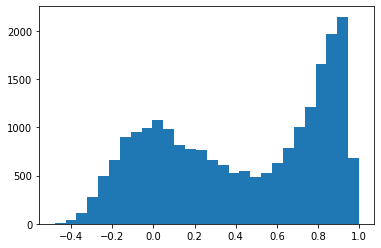

AUC score is 0.89386899200718  while binary score is 0.7002335609054977 and the confusion matrix is [[ 4486  6646]
 [   28 11104]] on dev loader after 10000 iterations and 1 epoch
Model is saved after 10000 iterations 
OCloss is 0.2314378446295412 and BCEloss is 0.6036004108192324 and MNRloss is 0.0 and Cosloss is 0.26639810600241187  and time taken is 4918.163344860077 after 10000 iterations
OCloss is 0.22858312614941967 and BCEloss is 0.6025483323362779 and MNRloss is 0.0 and Cosloss is 0.2641460346191931  and time taken is 5152.225142240524 after 10500 iterations
OCloss is 0.22621730597323322 and BCEloss is 0.6012666247891422 and MNRloss is 0.0 and Cosloss is 0.2624574791622773  and time taken is 5384.912065505981 after 11000 iterations
OCloss is 0.22484620161482624 and BCEloss is 0.6001706214772443 and MNRloss is 0.0 and Cosloss is 0.2605293750213588  and time taken is 5617.202851772308 after 11500 iterations
OCloss is 0.22272010505126616 and BCEloss is 0.5992122893059872 and MNRlo

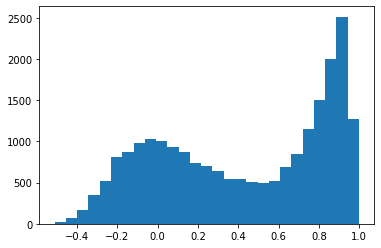

AUC score is 0.9056921002556488  while binary score is 0.7199964067553001 and the confusion matrix is [[ 4920  6212]
 [   22 11110]] on dev loader after 20000 iterations and 1 epoch
Model is saved after 20000 iterations 
OCloss is 0.1999203389823375 and BCEloss is 0.5877024448577729 and MNRloss is 0.0 and Cosloss is 0.23989624489845857  and time taken is 9897.071129322052 after 20000 iterations
OCloss is 0.19951398121584263 and BCEloss is 0.587188978559139 and MNRloss is 0.0 and Cosloss is 0.23902405361670773  and time taken is 10138.284892082214 after 20500 iterations
OCloss is 0.19859736637965372 and BCEloss is 0.5866652682950784 and MNRloss is 0.0 and Cosloss is 0.23823944504682004  and time taken is 10380.99274301529 after 21000 iterations
OCloss is 0.19776618526123244 and BCEloss is 0.5861889344734633 and MNRloss is 0.0 and Cosloss is 0.23741825211329365  and time taken is 10622.065120697021 after 21500 iterations
OCloss is 0.1971468478266292 and BCEloss is 0.58571007756893 and MN

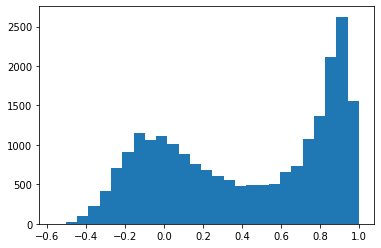

AUC score is 0.9135898426765194  while binary score is 0.7374236435501258 and the confusion matrix is [[ 5304  5828]
 [   18 11114]] on dev loader after 30000 iterations and 1 epoch
Model is saved after 30000 iterations 
OCloss is 0.1864481718423027 and BCEloss is 0.5797004028700308 and MNRloss is 0.0 and Cosloss is 0.22635545542340793  and time taken is 15013.417909145355 after 30000 iterations
OCloss is 0.18602465974351645 and BCEloss is 0.5793638993965157 and MNRloss is 0.0 and Cosloss is 0.22586115755497177  and time taken is 15252.720308065414 after 30500 iterations
OCloss is 0.185495154388037 and BCEloss is 0.5791365095649718 and MNRloss is 0.0 and Cosloss is 0.2253703368130553  and time taken is 15495.285603046417 after 31000 iterations
OCloss is 0.18481337356394884 and BCEloss is 0.578821329865235 and MNRloss is 0.0 and Cosloss is 0.22481336215133893  and time taken is 15737.662251234055 after 31500 iterations
OCloss is 0.1841228231734201 and BCEloss is 0.5784628347280878 and M

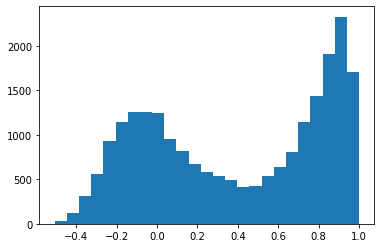

AUC score is 0.9231991080296503  while binary score is 0.7750628817822494 and the confusion matrix is [[ 6146  4986]
 [   22 11110]] on dev loader after 40000 iterations and 1 epoch
Model is saved after 40000 iterations 
OCloss is 0.17441482813764564 and BCEloss is 0.5739926946991364 and MNRloss is 0.0 and Cosloss is 0.21751565586803295  and time taken is 20144.996912956238 after 40000 iterations
OCloss is 0.1735992916874099 and BCEloss is 0.5736766593578005 and MNRloss is 0.0 and Cosloss is 0.2170622586835001  and time taken is 20385.796635627747 after 40500 iterations
OCloss is 0.17301001413093003 and BCEloss is 0.5734306384729427 and MNRloss is 0.0 and Cosloss is 0.21665235709155756  and time taken is 20627.702163934708 after 41000 iterations
OCloss is 0.17231836131366166 and BCEloss is 0.573145463617103 and MNRloss is 0.0 and Cosloss is 0.21617638728008248  and time taken is 20870.116263866425 after 41500 iterations
OCloss is 0.17178003325960076 and BCEloss is 0.5729144633856533 an

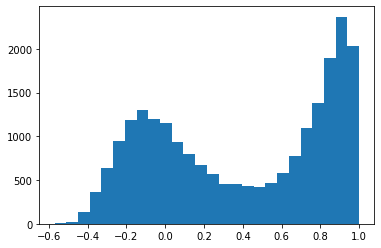

AUC score is 0.9256164876766525  while binary score is 0.7813510600071865 and the confusion matrix is [[ 6282  4850]
 [   18 11114]] on dev loader after 50000 iterations and 1 epoch
Model is saved after 50000 iterations 
OCloss is 0.16422820362020588 and BCEloss is 0.5694094203146255 and MNRloss is 0.0 and Cosloss is 0.2100754369382777  and time taken is 25254.810861587524 after 50000 iterations
OCloss is 0.16368277981195928 and BCEloss is 0.5692038498084896 and MNRloss is 0.0 and Cosloss is 0.20976884661655495  and time taken is 25494.89293241501 after 50500 iterations
OCloss is 0.16337867025123748 and BCEloss is 0.5690631938166241 and MNRloss is 0.0 and Cosloss is 0.20946887695015048  and time taken is 25736.786488056183 after 51000 iterations
OCloss is 0.16295058384498728 and BCEloss is 0.5689019341907076 and MNRloss is 0.0 and Cosloss is 0.2091698295692447  and time taken is 25978.28476381302 after 51500 iterations
OCloss is 0.16253337294966982 and BCEloss is 0.5687147639320024 and

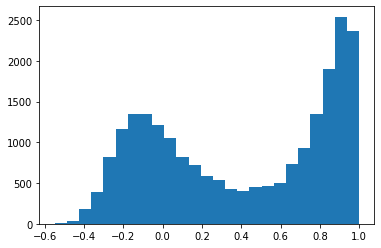

AUC score is 0.9228401377957051  while binary score is 0.7831476823571685 and the confusion matrix is [[ 6318  4814]
 [   14 11118]] on dev loader after 60000 iterations and 1 epoch
Model is saved after 60000 iterations 
OCloss is 0.15672994917073213 and BCEloss is 0.5658387085326173 and MNRloss is 0.0 and Cosloss is 0.20448667838584075  and time taken is 30340.344133138657 after 60000 iterations
OCloss is 0.15631662708100377 and BCEloss is 0.5656713157130187 and MNRloss is 0.0 and Cosloss is 0.20421562036090182  and time taken is 30577.987475156784 after 60500 iterations
OCloss is 0.1560654200412935 and BCEloss is 0.5655553563927294 and MNRloss is 0.0 and Cosloss is 0.20394717323809194  and time taken is 30817.63266658783 after 61000 iterations
OCloss is 0.15576688992657028 and BCEloss is 0.5654264946633887 and MNRloss is 0.0 and Cosloss is 0.2036963095931786  and time taken is 31057.818335056305 after 61500 iterations
OCloss is 0.1553259632567754 and BCEloss is 0.5652880182889344 and

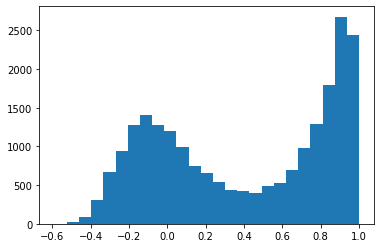

AUC score is 0.9291358725046317  while binary score is 0.7807222421846928 and the confusion matrix is [[ 6272  4860]
 [   22 11110]] on dev loader after 70000 iterations and 1 epoch
Model is saved after 70000 iterations 
OCloss is 0.15064010755313273 and BCEloss is 0.5631164553102392 and MNRloss is 0.0 and Cosloss is 0.19968894762423448  and time taken is 35398.606806993484 after 70000 iterations
OCloss is 0.15051387204562172 and BCEloss is 0.5629965176466646 and MNRloss is 0.0 and Cosloss is 0.19950574327963289  and time taken is 35637.921048402786 after 70500 iterations
OCloss is 0.15027431034148875 and BCEloss is 0.5628826570444376 and MNRloss is 0.0 and Cosloss is 0.1993200887219856  and time taken is 35877.44844222069 after 71000 iterations
OCloss is 0.15001393818699466 and BCEloss is 0.5627230500690094 and MNRloss is 0.0 and Cosloss is 0.19909985033490987  and time taken is 36116.05787396431 after 71500 iterations
OCloss is 0.14971149145657303 and BCEloss is 0.562576711847955 and

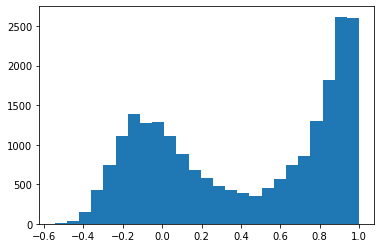

AUC score is 0.9264416921450946  while binary score is 0.7768595041322314 and the confusion matrix is [[ 6182  4950]
 [   18 11114]] on dev loader after 80000 iterations and 1 epoch
Model is saved after 80000 iterations 
OCloss is 0.14591840835521075 and BCEloss is 0.5606645646169751 and MNRloss is 0.0 and Cosloss is 0.19587193564605462  and time taken is 40443.33732318878 after 80000 iterations
OCloss is 0.14568544347539866 and BCEloss is 0.5605645585177255 and MNRloss is 0.0 and Cosloss is 0.1956701323278837  and time taken is 40680.28630757332 after 80500 iterations
OCloss is 0.14535304816321154 and BCEloss is 0.5604605620868341 and MNRloss is 0.0 and Cosloss is 0.1954763384226584  and time taken is 40917.65043306351 after 81000 iterations
OCloss is 0.14515690910176585 and BCEloss is 0.5603859654534187 and MNRloss is 0.0 and Cosloss is 0.19529199782977114  and time taken is 41154.46287274361 after 81500 iterations
OCloss is 0.14495558442790973 and BCEloss is 0.560291934073116 and MN

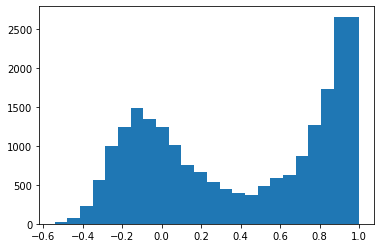

AUC score is 0.9296164086058689  while binary score is 0.7904240028745958 and the confusion matrix is [[ 6488  4644]
 [   22 11110]] on dev loader after 90000 iterations and 1 epoch
Model is saved after 90000 iterations 
OCloss is 0.1417345781027847 and BCEloss is 0.5587378247730113 and MNRloss is 0.0 and Cosloss is 0.1924394329891239  and time taken is 45461.18050146103 after 90000 iterations
OCloss is 0.14146928317287766 and BCEloss is 0.5586595462768918 and MNRloss is 0.0 and Cosloss is 0.1922648360833576  and time taken is 45695.18857836723 after 90500 iterations
OCloss is 0.14133103747659806 and BCEloss is 0.5585734855892766 and MNRloss is 0.0 and Cosloss is 0.19211631958483896  and time taken is 45932.695425987244 after 91000 iterations
OCloss is 0.1412283361661401 and BCEloss is 0.5584765059883009 and MNRloss is 0.0 and Cosloss is 0.1919621973085558  and time taken is 46169.214715480804 after 91500 iterations
OCloss is 0.14100795460099 and BCEloss is 0.5583848796002656 and MNRlo

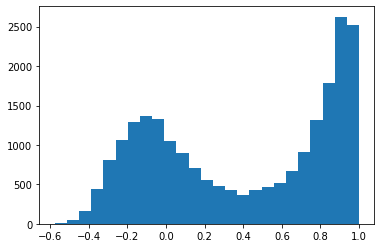

AUC score is 0.926841548502707  while binary score is 0.7981494789795185 and the confusion matrix is [[ 6656  4476]
 [   18 11114]] on dev loader after 100000 iterations and 1 epoch
Model is saved after 100000 iterations 
OCloss is 0.13824400623342092 and BCEloss is 0.5570092690263269 and MNRloss is 0.0 and Cosloss is 0.18942205149085542  and time taken is 50453.07572674751 after 100000 iterations
OCloss is 0.138033285625222 and BCEloss is 0.5569117938253666 and MNRloss is 0.0 and Cosloss is 0.1892844850412255  and time taken is 50684.76418042183 after 100500 iterations
OCloss is 0.13787190957256373 and BCEloss is 0.5568087928882985 and MNRloss is 0.0 and Cosloss is 0.18917080187515864  and time taken is 50920.001267910004 after 101000 iterations
OCloss is 0.13775333164767797 and BCEloss is 0.5567288270250421 and MNRloss is 0.0 and Cosloss is 0.18905293060497694  and time taken is 51155.74812912941 after 101500 iterations
OCloss is 0.1376005421155204 and BCEloss is 0.55667406699905 and

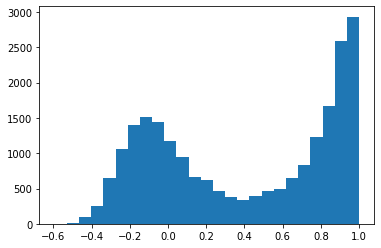

AUC score is 0.9267073029711522  while binary score is 0.8044376572044556 and the confusion matrix is [[ 6800  4332]
 [   22 11110]] on dev loader after 110000 iterations and 1 epoch
Model is saved after 110000 iterations 
OCloss is 0.1351921312724407 and BCEloss is 0.5555055283975932 and MNRloss is 0.0 and Cosloss is 0.18679789532982258  and time taken is 55376.744720220566 after 110000 iterations
OCloss is 0.1351282881952816 and BCEloss is 0.5554439967372249 and MNRloss is 0.0 and Cosloss is 0.18668401853789773  and time taken is 55605.71429634094 after 110500 iterations
OCloss is 0.13501677095952383 and BCEloss is 0.5553657843689536 and MNRloss is 0.0 and Cosloss is 0.18656596832950847  and time taken is 55836.2323243618 after 111000 iterations
OCloss is 0.1348345030514503 and BCEloss is 0.5552908298142316 and MNRloss is 0.0 and Cosloss is 0.18643934920393845  and time taken is 56066.170139074326 after 111500 iterations
OCloss is 0.13466561383225728 and BCEloss is 0.5552299692212347

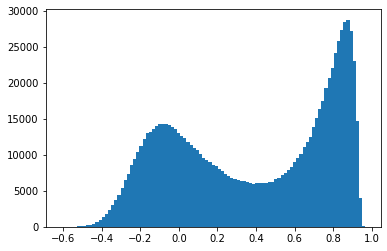

AUC and Bin_acc after training 1 on train dataloader is (0.9028818309154579, 0.754418615768385) and confusion matrix is [[235341 224870]
 [  1169 459044]]
Epoch 1/4
----------
OCloss is 0.6616074442863464 and BCEloss is 0.5602822303771973 and MNRloss is 0.0 and Cosloss is 0.19352927803993225  and time taken is 57698.23393750191 after 0 iterations
OCloss is 0.09559796927933639 and BCEloss is 0.5409718763804483 and MNRloss is 0.0 and Cosloss is 0.15721985512597117  and time taken is 57925.10182309151 after 500 iterations
OCloss is 0.10001442749478895 and BCEloss is 0.539484467926797 and MNRloss is 0.0 and Cosloss is 0.16120962072703449  and time taken is 58154.0014231205 after 1000 iterations
OCloss is 0.09669589606241859 and BCEloss is 0.5399805815874299 and MNRloss is 0.0 and Cosloss is 0.1595724683359196  and time taken is 58382.127834796906 after 1500 iterations
OCloss is 0.09713566156276648 and BCEloss is 0.5386252362152626 and MNRloss is 0.0 and Cosloss is 0.15866624895503734  and 

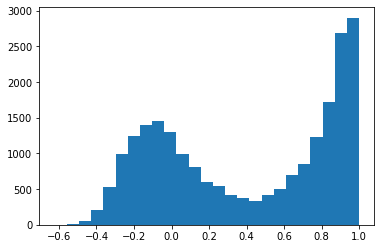

AUC score is 0.9294084025208483  while binary score is 0.799407114624506 and the confusion matrix is [[ 6680  4452]
 [   14 11118]] on dev loader after 10000 iterations and 2 epoch
Model is saved after 10000 iterations 
OCloss is 0.09516828292907589 and BCEloss is 0.5375537215656143 and MNRloss is 0.0 and Cosloss is 0.15534093012952627  and time taken is 62494.078892469406 after 10000 iterations
OCloss is 0.09570424070146456 and BCEloss is 0.5374019258891432 and MNRloss is 0.0 and Cosloss is 0.15553214030349005  and time taken is 62719.26176404953 after 10500 iterations
OCloss is 0.09531794701542692 and BCEloss is 0.5373006600264516 and MNRloss is 0.0 and Cosloss is 0.15547512721146045  and time taken is 62945.308760643005 after 11000 iterations
OCloss is 0.0952738667472554 and BCEloss is 0.537466371142857 and MNRloss is 0.0 and Cosloss is 0.1555447177643227  and time taken is 63170.19136047363 after 11500 iterations
OCloss is 0.09553258884096137 and BCEloss is 0.5377111738919715 and M

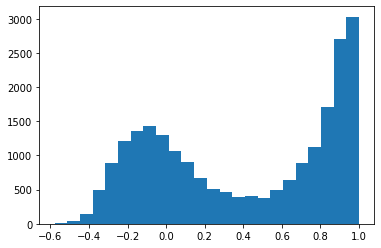

AUC score is 0.9312950240021576  while binary score is 0.7968918433345311 and the confusion matrix is [[ 6630  4502]
 [   20 11112]] on dev loader after 20000 iterations and 2 epoch
Model is saved after 20000 iterations 
OCloss is 0.0948869903823119 and BCEloss is 0.5372788462869632 and MNRloss is 0.0 and Cosloss is 0.15527425638710737  and time taken is 67266.44719099998 after 20000 iterations
OCloss is 0.09493167097251237 and BCEloss is 0.5373008919878068 and MNRloss is 0.0 and Cosloss is 0.155313444639518  and time taken is 67491.37642168999 after 20500 iterations
OCloss is 0.09477257124020094 and BCEloss is 0.5373682981033869 and MNRloss is 0.0 and Cosloss is 0.15533360093663498  and time taken is 67716.43400502205 after 21000 iterations
OCloss is 0.09522511596648149 and BCEloss is 0.5374331403710633 and MNRloss is 0.0 and Cosloss is 0.15526686893650185  and time taken is 67941.90223240852 after 21500 iterations
OCloss is 0.09515716517192571 and BCEloss is 0.5374495287271182 and MN

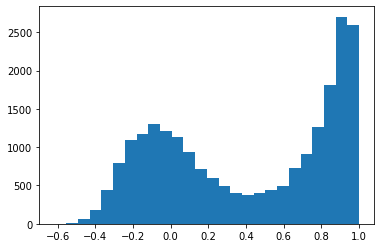

AUC score is 0.9362734309808514  while binary score is 0.776500179662235 and the confusion matrix is [[ 6172  4960]
 [   16 11116]] on dev loader after 30000 iterations and 2 epoch
Model is saved after 30000 iterations 
OCloss is 0.09622223953081809 and BCEloss is 0.5373603953402788 and MNRloss is 0.0 and Cosloss is 0.1551849656495398  and time taken is 72079.59047436714 after 30000 iterations
OCloss is 0.09626266285753349 and BCEloss is 0.5373054745832329 and MNRloss is 0.0 and Cosloss is 0.1552562079790417  and time taken is 72309.09962463379 after 30500 iterations
OCloss is 0.09629220189468174 and BCEloss is 0.5373165432528016 and MNRloss is 0.0 and Cosloss is 0.15511629945391825  and time taken is 72538.20951986313 after 31000 iterations
OCloss is 0.09598096276232826 and BCEloss is 0.5372625689437127 and MNRloss is 0.0 and Cosloss is 0.15503066989812667  and time taken is 72768.78296852112 after 31500 iterations
OCloss is 0.09600504270107886 and BCEloss is 0.5372459708634796 and MN

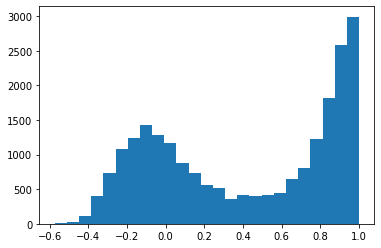

AUC score is 0.9322561624169778  while binary score is 0.7882680560546174 and the confusion matrix is [[ 6432  4700]
 [   14 11118]] on dev loader after 40000 iterations and 2 epoch
Model is saved after 40000 iterations 
OCloss is 0.09442456082100681 and BCEloss is 0.5367632036101702 and MNRloss is 0.0 and Cosloss is 0.15435113942019577  and time taken is 76979.1220831871 after 40000 iterations
OCloss is 0.094141295055336 and BCEloss is 0.5367573925025468 and MNRloss is 0.0 and Cosloss is 0.1543801328872198  and time taken is 77210.55216383934 after 40500 iterations
OCloss is 0.09394964127390659 and BCEloss is 0.5367012441998554 and MNRloss is 0.0 and Cosloss is 0.1542625301725669  and time taken is 77444.44557023048 after 41000 iterations
OCloss is 0.09376581372708939 and BCEloss is 0.5366106265942874 and MNRloss is 0.0 and Cosloss is 0.15417493904217017  and time taken is 77678.61500096321 after 41500 iterations
OCloss is 0.09370119744705654 and BCEloss is 0.5366046493605362 and MNRl

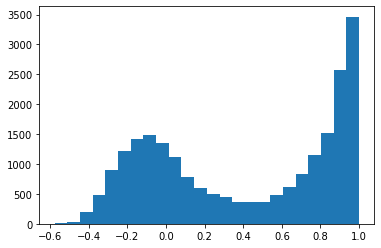

AUC score is 0.9318141287949511  while binary score is 0.8021918792669781 and the confusion matrix is [[ 6746  4386]
 [   18 11114]] on dev loader after 50000 iterations and 2 epoch
Model is saved after 50000 iterations 
OCloss is 0.09341043528580817 and BCEloss is 0.536415444072162 and MNRloss is 0.0 and Cosloss is 0.1536959179855521  and time taken is 81951.5280520916 after 50000 iterations
OCloss is 0.09323819042168754 and BCEloss is 0.5364137385456197 and MNRloss is 0.0 and Cosloss is 0.15365393107556244  and time taken is 82185.27773332596 after 50500 iterations
OCloss is 0.09336430870778664 and BCEloss is 0.5364441996202645 and MNRloss is 0.0 and Cosloss is 0.15366546166002104  and time taken is 82421.85355210304 after 51000 iterations
OCloss is 0.09329634487569988 and BCEloss is 0.5364089132001086 and MNRloss is 0.0 and Cosloss is 0.15363004626867685  and time taken is 82658.60967373848 after 51500 iterations
OCloss is 0.09315477872030803 and BCEloss is 0.536371741755573 and MNR

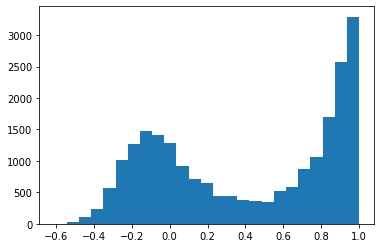

AUC score is 0.9318590538717254  while binary score is 0.7996766079770032 and the confusion matrix is [[ 6692  4440]
 [   20 11112]] on dev loader after 60000 iterations and 2 epoch
Model is saved after 60000 iterations 
OCloss is 0.09302009693018512 and BCEloss is 0.5361534264014722 and MNRloss is 0.0 and Cosloss is 0.15324220373021716  and time taken is 86961.14195179939 after 60000 iterations
OCloss is 0.0930505004816892 and BCEloss is 0.5361096128577294 and MNRloss is 0.0 and Cosloss is 0.15322500936474692  and time taken is 87198.5474832058 after 60500 iterations
OCloss is 0.09296719207359985 and BCEloss is 0.5360686182487214 and MNRloss is 0.0 and Cosloss is 0.153200798094345  and time taken is 87435.89924502373 after 61000 iterations
OCloss is 0.09301498419538676 and BCEloss is 0.5360537638501581 and MNRloss is 0.0 and Cosloss is 0.15319072667377337  and time taken is 87674.9407093525 after 61500 iterations
OCloss is 0.09309230747414063 and BCEloss is 0.5360599020529507 and MNRl

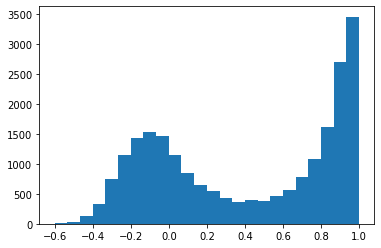

AUC score is 0.930843687545515  while binary score is 0.8056952928494431 and the confusion matrix is [[ 6832  4300]
 [   26 11106]] on dev loader after 70000 iterations and 2 epoch
Model is saved after 70000 iterations 
OCloss is 0.09298223024697538 and BCEloss is 0.535910596423632 and MNRloss is 0.0 and Cosloss is 0.1527005553714901  and time taken is 91995.67391324043 after 70000 iterations
OCloss is 0.09292975886303967 and BCEloss is 0.5358931922609591 and MNRloss is 0.0 and Cosloss is 0.15266834513473507  and time taken is 92231.29343366623 after 70500 iterations
OCloss is 0.0928209130956912 and BCEloss is 0.5358448283576396 and MNRloss is 0.0 and Cosloss is 0.15262377227619808  and time taken is 92469.94152379036 after 71000 iterations
OCloss is 0.09274072505420208 and BCEloss is 0.5358626142854239 and MNRloss is 0.0 and Cosloss is 0.15257530508924042  and time taken is 92708.06352806091 after 71500 iterations
OCloss is 0.09256476538980712 and BCEloss is 0.5358422116330709 and MNR

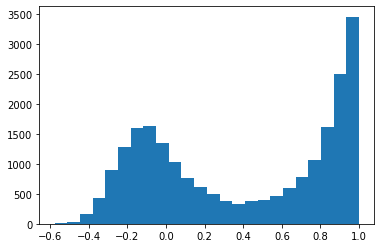

AUC score is 0.9330009188850062  while binary score is 0.8166546891843335 and the confusion matrix is [[ 7072  4060]
 [   22 11110]] on dev loader after 80000 iterations and 2 epoch
Model is saved after 80000 iterations 
OCloss is 0.09214599358156773 and BCEloss is 0.5357009905429708 and MNRloss is 0.0 and Cosloss is 0.15206006809252873  and time taken is 97045.21669769287 after 80000 iterations
OCloss is 0.09208402856164721 and BCEloss is 0.5356705885617117 and MNRloss is 0.0 and Cosloss is 0.15200899142961727  and time taken is 97284.21410918236 after 80500 iterations
OCloss is 0.09207885041972459 and BCEloss is 0.535643227307426 and MNRloss is 0.0 and Cosloss is 0.1519472181924025  and time taken is 97523.83464312553 after 81000 iterations
OCloss is 0.09203686664990096 and BCEloss is 0.5356279183876423 and MNRloss is 0.0 and Cosloss is 0.15189826170735796  and time taken is 97762.54620170593 after 81500 iterations
OCloss is 0.09209647877043978 and BCEloss is 0.5356119298400391 and M

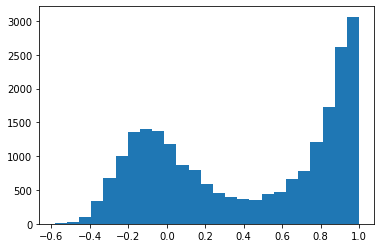

AUC score is 0.9332253456318396  while binary score is 0.7917714696370823 and the confusion matrix is [[ 6510  4622]
 [   14 11118]] on dev loader after 90000 iterations and 2 epoch
Model is saved after 90000 iterations 
OCloss is 0.09156888948442923 and BCEloss is 0.5354584251790191 and MNRloss is 0.0 and Cosloss is 0.15152167568271283  and time taken is 102100.72898459435 after 90000 iterations
OCloss is 0.09146147072372236 and BCEloss is 0.5354329300154504 and MNRloss is 0.0 and Cosloss is 0.1514695511286043  and time taken is 102338.55192065239 after 90500 iterations
OCloss is 0.09152892647584955 and BCEloss is 0.5354315594451597 and MNRloss is 0.0 and Cosloss is 0.1514581928615723  and time taken is 102578.87355542183 after 91000 iterations
OCloss is 0.09152344187993079 and BCEloss is 0.5353839017870236 and MNRloss is 0.0 and Cosloss is 0.15143422835593198  and time taken is 102818.66150403023 after 91500 iterations
OCloss is 0.09153238546884374 and BCEloss is 0.5353888358518202 a

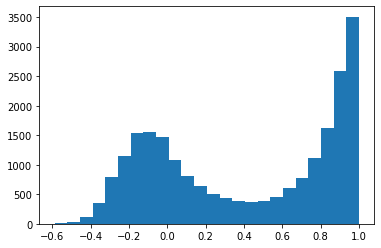

AUC score is 0.9326842252339945  while binary score is 0.8069529284944305 and the confusion matrix is [[ 6848  4284]
 [   14 11118]] on dev loader after 100000 iterations and 2 epoch
Model is saved after 100000 iterations 
OCloss is 0.09139559240919651 and BCEloss is 0.5352100752529276 and MNRloss is 0.0 and Cosloss is 0.15102017208250906  and time taken is 107173.09436893463 after 100000 iterations
OCloss is 0.09136686096916838 and BCEloss is 0.5352112599617723 and MNRloss is 0.0 and Cosloss is 0.15098264318562882  and time taken is 107408.22306752205 after 100500 iterations
OCloss is 0.09139885953110817 and BCEloss is 0.535213313434463 and MNRloss is 0.0 and Cosloss is 0.15096869116479303  and time taken is 107648.582249403 after 101000 iterations
OCloss is 0.09136645283252452 and BCEloss is 0.5352091629257157 and MNRloss is 0.0 and Cosloss is 0.15093536823767886  and time taken is 107889.5304658413 after 101500 iterations
OCloss is 0.09136627829585009 and BCEloss is 0.53521047336405

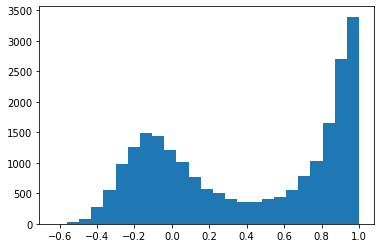

AUC score is 0.9322640085799812  while binary score is 0.8089292130794107 and the confusion matrix is [[ 6894  4238]
 [   16 11116]] on dev loader after 110000 iterations and 2 epoch
Model is saved after 110000 iterations 
OCloss is 0.09083673878462514 and BCEloss is 0.5350603919821602 and MNRloss is 0.0 and Cosloss is 0.15050167734983746  and time taken is 112235.69962787628 after 110000 iterations
OCloss is 0.0908781474421672 and BCEloss is 0.5350718564320415 and MNRloss is 0.0 and Cosloss is 0.1504962080335183  and time taken is 112474.46740412712 after 110500 iterations
OCloss is 0.09082066190123736 and BCEloss is 0.5350476616491123 and MNRloss is 0.0 and Cosloss is 0.15047106143702763  and time taken is 112713.37297558784 after 111000 iterations
OCloss is 0.09084482745095236 and BCEloss is 0.5350512962936451 and MNRloss is 0.0 and Cosloss is 0.15046432888309672  and time taken is 112953.10839366913 after 111500 iterations
OCloss is 0.09080394117328064 and BCEloss is 0.535019815083

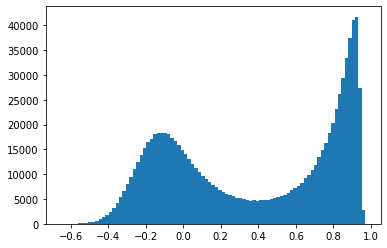

AUC and Bin_acc after training 2 on train dataloader is (0.9316532154085042, 0.806814033532372) and confusion matrix is [[283151 177061]
 [   752 459460]]
Epoch 2/4
----------
OCloss is 0.0 and BCEloss is 0.4604686498641968 and MNRloss is 0.0 and Cosloss is 0.20543928444385529  and time taken is 114652.94718670845 after 0 iterations
OCloss is 0.06141045167026744 and BCEloss is 0.5300683504093193 and MNRloss is 0.0 and Cosloss is 0.14042155094771924  and time taken is 114889.60778856277 after 500 iterations
OCloss is 0.06886946113488696 and BCEloss is 0.5293744612526108 and MNRloss is 0.0 and Cosloss is 0.14130936708342243  and time taken is 115127.7669262886 after 1000 iterations
OCloss is 0.07175011689978443 and BCEloss is 0.5313233217344849 and MNRloss is 0.0 and Cosloss is 0.1425165991763585  and time taken is 115367.38767361641 after 1500 iterations
OCloss is 0.07111125898116662 and BCEloss is 0.5307595073164015 and MNRloss is 0.0 and Cosloss is 0.14271074593782068  and time taken 

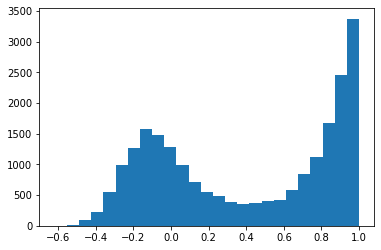

AUC score is 0.9343975027934244  while binary score is 0.8109953287818901 and the confusion matrix is [[ 6940  4192]
 [   16 11116]] on dev loader after 10000 iterations and 3 epoch
Model is saved after 10000 iterations 
OCloss is 0.07400650394210434 and BCEloss is 0.5309806156010642 and MNRloss is 0.0 and Cosloss is 0.1418725806531472  and time taken is 119698.27760624886 after 10000 iterations
OCloss is 0.07474195999309877 and BCEloss is 0.5312396498955201 and MNRloss is 0.0 and Cosloss is 0.14195070653195452  and time taken is 119934.39650607109 after 10500 iterations
OCloss is 0.0747899277608514 and BCEloss is 0.5312510821919215 and MNRloss is 0.0 and Cosloss is 0.14205074841620527  and time taken is 120173.54753684998 after 11000 iterations
OCloss is 0.07503928544911447 and BCEloss is 0.5312591195028767 and MNRloss is 0.0 and Cosloss is 0.1420054215003453  and time taken is 120410.7138414383 after 11500 iterations
OCloss is 0.07525715861208884 and BCEloss is 0.5312475311081665 and

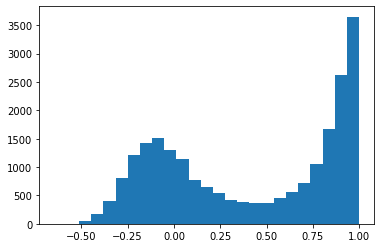

AUC score is 0.9342060497949087  while binary score is 0.7974308300395256 and the confusion matrix is [[ 6638  4494]
 [   16 11116]] on dev loader after 20000 iterations and 3 epoch
Model is saved after 20000 iterations 
OCloss is 0.07652798781614938 and BCEloss is 0.5305334716077197 and MNRloss is 0.0 and Cosloss is 0.14182404760024242  and time taken is 124727.14450740814 after 20000 iterations
OCloss is 0.0768207944676407 and BCEloss is 0.5304984604984974 and MNRloss is 0.0 and Cosloss is 0.14180316265000018  and time taken is 124962.60819244385 after 20500 iterations
OCloss is 0.07679074517262559 and BCEloss is 0.53043051166118 and MNRloss is 0.0 and Cosloss is 0.1417786621434173  and time taken is 125200.75578427315 after 21000 iterations
OCloss is 0.07693768640692104 and BCEloss is 0.5304670643570267 and MNRloss is 0.0 and Cosloss is 0.14171421166593334  and time taken is 125437.99735474586 after 21500 iterations
OCloss is 0.07743775785247173 and BCEloss is 0.5305819342116985 and

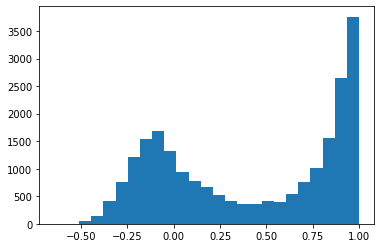

AUC score is 0.9335720334755981  while binary score is 0.8049766439094502 and the confusion matrix is [[ 6814  4318]
 [   24 11108]] on dev loader after 30000 iterations and 3 epoch
Model is saved after 30000 iterations 
OCloss is 0.07780761163261658 and BCEloss is 0.5304450865878784 and MNRloss is 0.0 and Cosloss is 0.14163188625911285  and time taken is 129760.19608354568 after 30000 iterations
OCloss is 0.07786662386154562 and BCEloss is 0.530445449981747 and MNRloss is 0.0 and Cosloss is 0.14164435769040104  and time taken is 129995.01453876495 after 30500 iterations
OCloss is 0.07764401779336541 and BCEloss is 0.5304459481667151 and MNRloss is 0.0 and Cosloss is 0.1415966753765395  and time taken is 130231.36840963364 after 31000 iterations
OCloss is 0.07772587611391918 and BCEloss is 0.5304452911951683 and MNRloss is 0.0 and Cosloss is 0.1416285632712151  and time taken is 130468.22302556038 after 31500 iterations
OCloss is 0.07778830307761557 and BCEloss is 0.5304144256554754 an

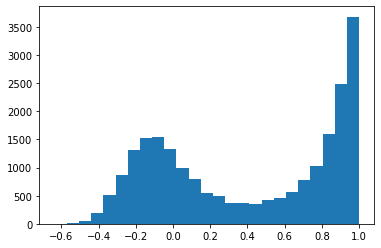

AUC score is 0.9326714793573858  while binary score is 0.811893639956881 and the confusion matrix is [[ 6966  4166]
 [   22 11110]] on dev loader after 40000 iterations and 3 epoch
Model is saved after 40000 iterations 
OCloss is 0.07778434834831126 and BCEloss is 0.5302535383594814 and MNRloss is 0.0 and Cosloss is 0.14112380439367228  and time taken is 134763.82062602043 after 40000 iterations
OCloss is 0.07777130052572334 and BCEloss is 0.5302829626573374 and MNRloss is 0.0 and Cosloss is 0.14107873237530727  and time taken is 134998.55450606346 after 40500 iterations
OCloss is 0.07795892102180779 and BCEloss is 0.5302678697435034 and MNRloss is 0.0 and Cosloss is 0.14120431290630248  and time taken is 135233.44788336754 after 41000 iterations
OCloss is 0.0779313547311748 and BCEloss is 0.5302803984431111 and MNRloss is 0.0 and Cosloss is 0.14122093608847208  and time taken is 135468.50054001808 after 41500 iterations
OCloss is 0.07785941208512914 and BCEloss is 0.5303063234924767 a

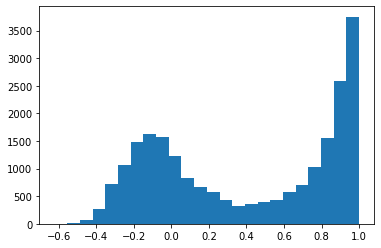

AUC score is 0.9374326767349623  while binary score is 0.8161157024793388 and the confusion matrix is [[ 7056  4076]
 [   18 11114]] on dev loader after 50000 iterations and 3 epoch
Model is saved after 50000 iterations 
OCloss is 0.07770086430672365 and BCEloss is 0.5302620685002091 and MNRloss is 0.0 and Cosloss is 0.14093989100357024  and time taken is 139733.32869315147 after 50000 iterations
OCloss is 0.07767213634070648 and BCEloss is 0.5302950554446549 and MNRloss is 0.0 and Cosloss is 0.14093077333958934  and time taken is 139964.4201786518 after 50500 iterations
OCloss is 0.07771778285086803 and BCEloss is 0.530312441170364 and MNRloss is 0.0 and Cosloss is 0.14092897715750766  and time taken is 140199.06943416595 after 51000 iterations
OCloss is 0.0775903375431467 and BCEloss is 0.5303345649097176 and MNRloss is 0.0 and Cosloss is 0.14089038278711827  and time taken is 140433.36330413818 after 51500 iterations
OCloss is 0.07783346459943914 and BCEloss is 0.530396121893591 and

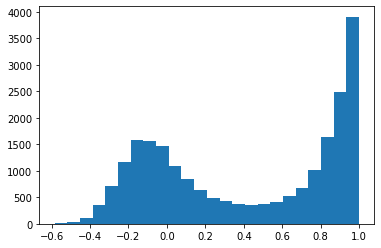

AUC score is 0.9346452362860567  while binary score is 0.8024613726194754 and the confusion matrix is [[ 6754  4378]
 [   20 11112]] on dev loader after 60000 iterations and 3 epoch
Model is saved after 60000 iterations 
OCloss is 0.07765424936400626 and BCEloss is 0.5303618584712766 and MNRloss is 0.0 and Cosloss is 0.14071518403113212  and time taken is 144695.6330587864 after 60000 iterations
OCloss is 0.07757935246688763 and BCEloss is 0.5303285002597109 and MNRloss is 0.0 and Cosloss is 0.14067510815152817  and time taken is 144928.44313144684 after 60500 iterations
OCloss is 0.07755833513349018 and BCEloss is 0.530351871429503 and MNRloss is 0.0 and Cosloss is 0.14067238497624363  and time taken is 145162.8162765503 after 61000 iterations
OCloss is 0.07754189386825237 and BCEloss is 0.5303625409371411 and MNRloss is 0.0 and Cosloss is 0.14066042159445838  and time taken is 145397.8360016346 after 61500 iterations
OCloss is 0.07751442900789932 and BCEloss is 0.530332184629466 and 

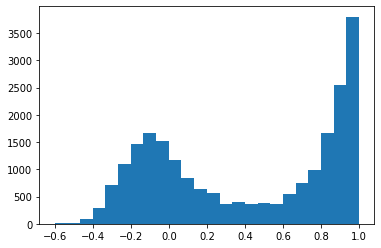

AUC score is 0.9380320308911316  while binary score is 0.8068630973769314 and the confusion matrix is [[ 6848  4284]
 [   16 11116]] on dev loader after 70000 iterations and 3 epoch
Model is saved after 70000 iterations 
OCloss is 0.07761640143169632 and BCEloss is 0.5303065750156511 and MNRloss is 0.0 and Cosloss is 0.1404123120901611  and time taken is 149626.76164245605 after 70000 iterations
OCloss is 0.07755905547661467 and BCEloss is 0.5302698974828277 and MNRloss is 0.0 and Cosloss is 0.1403933066122981  and time taken is 149859.01827454567 after 70500 iterations
OCloss is 0.0775417222594404 and BCEloss is 0.5302779521444791 and MNRloss is 0.0 and Cosloss is 0.14038491880643947  and time taken is 150091.4132733345 after 71000 iterations
OCloss is 0.07755513408490047 and BCEloss is 0.5302760497074648 and MNRloss is 0.0 and Cosloss is 0.140361354560383  and time taken is 150322.71295928955 after 71500 iterations
OCloss is 0.07742283793441124 and BCEloss is 0.5302995272612294 and M

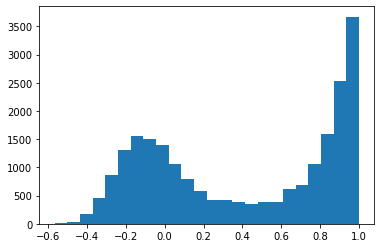

AUC score is 0.9363855946950086  while binary score is 0.806503772906935 and the confusion matrix is [[ 6840  4292]
 [   16 11116]] on dev loader after 80000 iterations and 3 epoch
Model is saved after 80000 iterations 
OCloss is 0.07721321033412228 and BCEloss is 0.5302500343379676 and MNRloss is 0.0 and Cosloss is 0.14015866301825616  and time taken is 154497.3604695797 after 80000 iterations
OCloss is 0.0773164933456452 and BCEloss is 0.5302562250804282 and MNRloss is 0.0 and Cosloss is 0.14018047649711662  and time taken is 154726.78856420517 after 80500 iterations
OCloss is 0.07741243127708358 and BCEloss is 0.5302734007637562 and MNRloss is 0.0 and Cosloss is 0.1401881842587661  and time taken is 154957.06926608086 after 81000 iterations
OCloss is 0.07739813905248735 and BCEloss is 0.5302574971445754 and MNRloss is 0.0 and Cosloss is 0.14017376150254848  and time taken is 155186.89000463486 after 81500 iterations
OCloss is 0.07735774755051203 and BCEloss is 0.5302384675288336 and

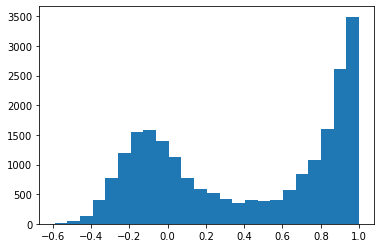

AUC score is 0.9362826676031211  while binary score is 0.8117139777218828 and the confusion matrix is [[ 6954  4178]
 [   14 11118]] on dev loader after 90000 iterations and 3 epoch
Model is saved after 90000 iterations 
OCloss is 0.07724911480967131 and BCEloss is 0.5301092148480805 and MNRloss is 0.0 and Cosloss is 0.14010812555537647  and time taken is 159389.9582283497 after 90000 iterations
OCloss is 0.07723093845479112 and BCEloss is 0.5301012046831663 and MNRloss is 0.0 and Cosloss is 0.14009002865464487  and time taken is 159622.494038105 after 90500 iterations
OCloss is 0.07716455549890666 and BCEloss is 0.5300879652652163 and MNRloss is 0.0 and Cosloss is 0.14006065837990386  and time taken is 159854.6799237728 after 91000 iterations
OCloss is 0.07717223923535571 and BCEloss is 0.5300767128213458 and MNRloss is 0.0 and Cosloss is 0.14005306172380502  and time taken is 160090.74983000755 after 91500 iterations
OCloss is 0.07718731898345756 and BCEloss is 0.5300807062750235 and

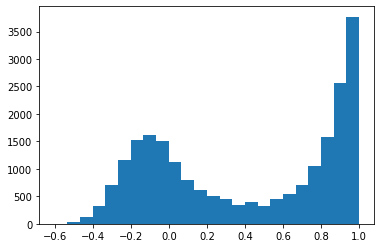

AUC score is 0.93525167516325  while binary score is 0.8169241825368307 and the confusion matrix is [[ 7068  4064]
 [   12 11120]] on dev loader after 100000 iterations and 3 epoch
Model is saved after 100000 iterations 
OCloss is 0.07727554619383968 and BCEloss is 0.5299497888022209 and MNRloss is 0.0 and Cosloss is 0.1398206658234214  and time taken is 164377.0533530712 after 100000 iterations
OCloss is 0.07719348799401049 and BCEloss is 0.5299420692066277 and MNRloss is 0.0 and Cosloss is 0.13980478345078304  and time taken is 164613.39857816696 after 100500 iterations
OCloss is 0.07715076484331213 and BCEloss is 0.5299391075270166 and MNRloss is 0.0 and Cosloss is 0.13978839919631308  and time taken is 164851.85486006737 after 101000 iterations
OCloss is 0.07717579725719444 and BCEloss is 0.5299212435943935 and MNRloss is 0.0 and Cosloss is 0.13977896396640546  and time taken is 165089.5099606514 after 101500 iterations
OCloss is 0.07718826219991613 and BCEloss is 0.529910963404883

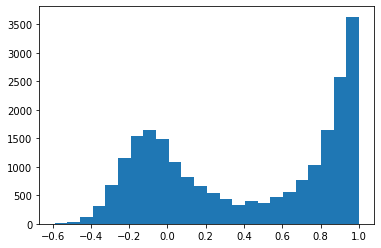

AUC score is 0.9351785436270714  while binary score is 0.8055156306144449 and the confusion matrix is [[ 6816  4316]
 [   14 11118]] on dev loader after 110000 iterations and 3 epoch
Model is saved after 110000 iterations 
OCloss is 0.07709623573865199 and BCEloss is 0.5298246667803002 and MNRloss is 0.0 and Cosloss is 0.1395688855749299  and time taken is 169430.33061289787 after 110000 iterations
OCloss is 0.07705773197572699 and BCEloss is 0.5298125241937368 and MNRloss is 0.0 and Cosloss is 0.13954454411028896  and time taken is 169668.2408299446 after 110500 iterations
OCloss is 0.07708827920920204 and BCEloss is 0.5298190981461387 and MNRloss is 0.0 and Cosloss is 0.13954093118414498  and time taken is 169909.09899020195 after 111000 iterations
OCloss is 0.07708093204248101 and BCEloss is 0.5298118336363372 and MNRloss is 0.0 and Cosloss is 0.1395337577152248  and time taken is 170148.42308712006 after 111500 iterations
OCloss is 0.07703833707274543 and BCEloss is 0.5297886357757

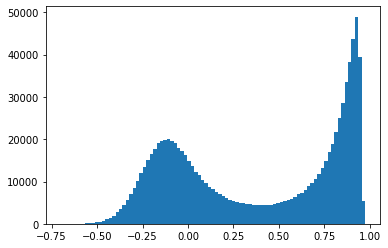

AUC and Bin_acc after training 3 on train dataloader is (0.9402706562613854, 0.8191300965641921) and confusion matrix is [[294327 165885]
 [   592 459620]]
Epoch 3/4
----------
OCloss is 0.0 and BCEloss is 0.5998262763023376 and MNRloss is 0.0 and Cosloss is 0.18018987774848938  and time taken is 171850.96588492393 after 0 iterations
OCloss is 0.06273226830098348 and BCEloss is 0.525108562496132 and MNRloss is 0.0 and Cosloss is 0.13630996703610807  and time taken is 172089.6061015129 after 500 iterations
OCloss is 0.06270937395463223 and BCEloss is 0.526433013119064 and MNRloss is 0.0 and Cosloss is 0.13611668311841005  and time taken is 172328.3425269127 after 1000 iterations
OCloss is 0.0676923381719473 and BCEloss is 0.5256124476565273 and MNRloss is 0.0 and Cosloss is 0.13493262221174268  and time taken is 172568.29556822777 after 1500 iterations
OCloss is 0.06841296515029892 and BCEloss is 0.5266466317088648 and MNRloss is 0.0 and Cosloss is 0.13427766168425823  and time taken is

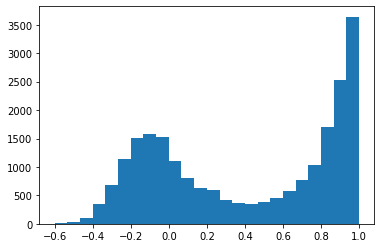

AUC score is 0.9393346925867211  while binary score is 0.808390226374416 and the confusion matrix is [[ 6886  4246]
 [   20 11112]] on dev loader after 10000 iterations and 4 epoch
Model is saved after 10000 iterations 
OCloss is 0.07068261228726985 and BCEloss is 0.5267082990503182 and MNRloss is 0.0 and Cosloss is 0.13477110751547794  and time taken is 176929.29096627235 after 10000 iterations
OCloss is 0.07109878755392292 and BCEloss is 0.5270066227774179 and MNRloss is 0.0 and Cosloss is 0.13495915214569348  and time taken is 177170.10753631592 after 10500 iterations
OCloss is 0.07070550321454878 and BCEloss is 0.5271744975804438 and MNRloss is 0.0 and Cosloss is 0.13523489306771866  and time taken is 177412.22487044334 after 11000 iterations
OCloss is 0.0709885621082426 and BCEloss is 0.5270652845288119 and MNRloss is 0.0 and Cosloss is 0.1352399344006682  and time taken is 177654.87467122078 after 11500 iterations
OCloss is 0.07111158197178791 and BCEloss is 0.5271864649469917 an

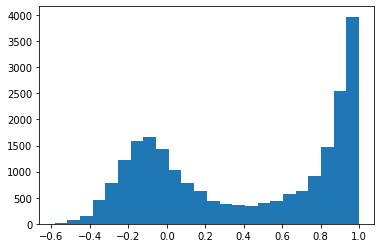

AUC score is 0.9352218133951953  while binary score is 0.820697089471793 and the confusion matrix is [[ 7162  3970]
 [   22 11110]] on dev loader after 20000 iterations and 4 epoch
Model is saved after 20000 iterations 
OCloss is 0.0686346995566961 and BCEloss is 0.526551780100316 and MNRloss is 0.0 and Cosloss is 0.13378649257073863  and time taken is 182050.5317223072 after 20000 iterations
OCloss is 0.06845926475283268 and BCEloss is 0.5265314182411327 and MNRloss is 0.0 and Cosloss is 0.13376234507376847  and time taken is 182289.69756054878 after 20500 iterations
OCloss is 0.06829232180684275 and BCEloss is 0.5266107818602517 and MNRloss is 0.0 and Cosloss is 0.1337950742227366  and time taken is 182530.34558343887 after 21000 iterations
OCloss is 0.0679805579842086 and BCEloss is 0.5265040849329211 and MNRloss is 0.0 and Cosloss is 0.13365403475797974  and time taken is 182771.35839247704 after 21500 iterations
OCloss is 0.06818423645852158 and BCEloss is 0.5265698176972687 and M

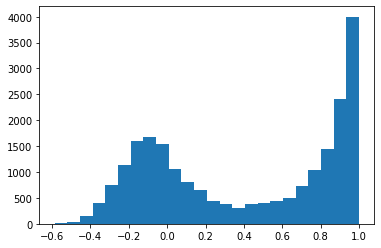

AUC score is 0.9382507964823805  while binary score is 0.8183614804168163 and the confusion matrix is [[ 7106  4026]
 [   18 11114]] on dev loader after 30000 iterations and 4 epoch
Model is saved after 30000 iterations 
OCloss is 0.06821146967304925 and BCEloss is 0.5267354130133014 and MNRloss is 0.0 and Cosloss is 0.1334090291850684  and time taken is 187167.43171095848 after 30000 iterations
OCloss is 0.06832646008062955 and BCEloss is 0.5267117823785589 and MNRloss is 0.0 and Cosloss is 0.1334330172925272  and time taken is 187409.83855104446 after 30500 iterations
OCloss is 0.06812105675367584 and BCEloss is 0.5266966596310656 and MNRloss is 0.0 and Cosloss is 0.13337941861996663  and time taken is 187653.86530542374 after 31000 iterations
OCloss is 0.06804721078401883 and BCEloss is 0.5267087004976853 and MNRloss is 0.0 and Cosloss is 0.13341370701139582  and time taken is 187897.21395468712 after 31500 iterations
OCloss is 0.06809191888810606 and BCEloss is 0.5267461589545274 a

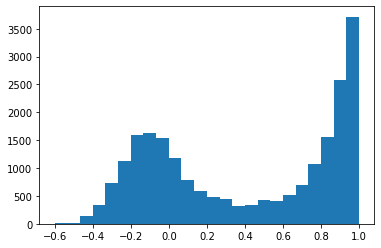

AUC score is 0.9379308584264138  while binary score is 0.8196191160618038 and the confusion matrix is [[ 7134  3998]
 [   18 11114]] on dev loader after 40000 iterations and 4 epoch
Model is saved after 40000 iterations 
OCloss is 0.06833578060823899 and BCEloss is 0.5269469844559151 and MNRloss is 0.0 and Cosloss is 0.13325370039938514  and time taken is 192293.83844923973 after 40000 iterations
OCloss is 0.06824250767732341 and BCEloss is 0.5269100989764957 and MNRloss is 0.0 and Cosloss is 0.13326655223960712  and time taken is 192534.18858337402 after 40500 iterations
OCloss is 0.06811558533294551 and BCEloss is 0.5269533362905502 and MNRloss is 0.0 and Cosloss is 0.13323735593829814  and time taken is 192777.00381994247 after 41000 iterations
OCloss is 0.06824416156326588 and BCEloss is 0.5269486543480245 and MNRloss is 0.0 and Cosloss is 0.13323963996993948  and time taken is 193018.70959448814 after 41500 iterations
OCloss is 0.06820862004783974 and BCEloss is 0.526945213718541 

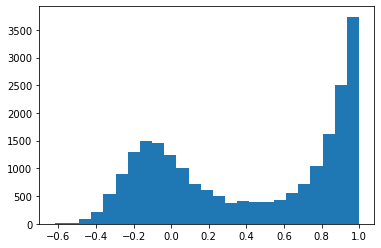

AUC score is 0.9354213442999253  while binary score is 0.8019223859144807 and the confusion matrix is [[ 6734  4398]
 [   12 11120]] on dev loader after 50000 iterations and 4 epoch
Model is saved after 50000 iterations 
OCloss is 0.06852290898902874 and BCEloss is 0.5269187570526582 and MNRloss is 0.0 and Cosloss is 0.1331079168394919  and time taken is 197410.62311530113 after 50000 iterations
OCloss is 0.06850257757176967 and BCEloss is 0.5269389710013993 and MNRloss is 0.0 and Cosloss is 0.13309427928919998  and time taken is 197652.21637439728 after 50500 iterations
OCloss is 0.06866466113596362 and BCEloss is 0.5269450436844335 and MNRloss is 0.0 and Cosloss is 0.13315546067731987  and time taken is 197894.43314051628 after 51000 iterations
OCloss is 0.06870986493888692 and BCEloss is 0.5269783752542919 and MNRloss is 0.0 and Cosloss is 0.13320891073004268  and time taken is 198135.81482195854 after 51500 iterations
OCloss is 0.06871212504988153 and BCEloss is 0.5269745844024546 

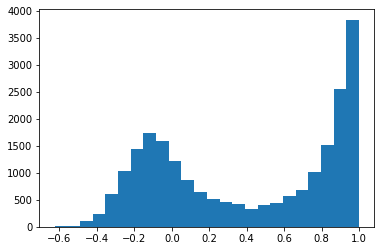

AUC score is 0.9369075466186809  while binary score is 0.8178224937118218 and the confusion matrix is [[ 7092  4040]
 [   16 11116]] on dev loader after 60000 iterations and 4 epoch
Model is saved after 60000 iterations 
OCloss is 0.06883312107004237 and BCEloss is 0.5270146762430087 and MNRloss is 0.0 and Cosloss is 0.13318510135718697  and time taken is 202513.99770379066 after 60000 iterations
OCloss is 0.06873938633988369 and BCEloss is 0.5270034258520226 and MNRloss is 0.0 and Cosloss is 0.13317112862949207  and time taken is 202754.32436823845 after 60500 iterations
OCloss is 0.06870072711812243 and BCEloss is 0.5269798243233021 and MNRloss is 0.0 and Cosloss is 0.13315352465639338  and time taken is 202995.57898402214 after 61000 iterations
OCloss is 0.06876827652907402 and BCEloss is 0.5269906946549433 and MNRloss is 0.0 and Cosloss is 0.13318877062306905  and time taken is 203236.57027101517 after 61500 iterations
OCloss is 0.06889083506693063 and BCEloss is 0.5269698307046244

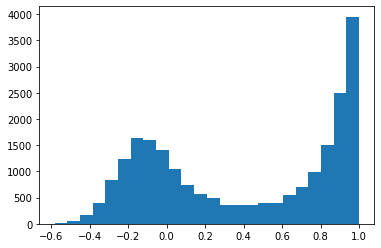

AUC score is 0.9353685730601478  while binary score is 0.8186309737693137 and the confusion matrix is [[ 7110  4022]
 [   16 11116]] on dev loader after 70000 iterations and 4 epoch
Model is saved after 70000 iterations 
OCloss is 0.0690536268219455 and BCEloss is 0.5269173538661344 and MNRloss is 0.0 and Cosloss is 0.13328283352017287  and time taken is 207619.75902557373 after 70000 iterations
OCloss is 0.06898279119992405 and BCEloss is 0.5269198572717997 and MNRloss is 0.0 and Cosloss is 0.13327093670417894  and time taken is 207858.07232022285 after 70500 iterations
OCloss is 0.06899662151202636 and BCEloss is 0.5269153909688868 and MNRloss is 0.0 and Cosloss is 0.13326441507665002  and time taken is 208099.08302521706 after 71000 iterations
OCloss is 0.06900449671467966 and BCEloss is 0.5269128045223521 and MNRloss is 0.0 and Cosloss is 0.1332689239068054  and time taken is 208340.35201931 after 71500 iterations
OCloss is 0.06911489601923687 and BCEloss is 0.5268968355183641 and 

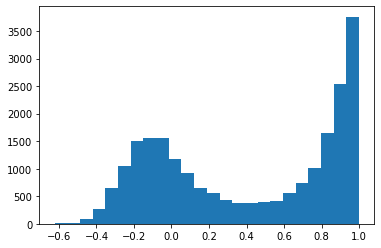

AUC score is 0.9401997899936401  while binary score is 0.8125224577793748 and the confusion matrix is [[ 6976  4156]
 [   18 11114]] on dev loader after 80000 iterations and 4 epoch
Model is saved after 80000 iterations 
OCloss is 0.06900569925361555 and BCEloss is 0.52694676226627 and MNRloss is 0.0 and Cosloss is 0.13323879105329922  and time taken is 212714.3582520485 after 80000 iterations
OCloss is 0.06903944345361478 and BCEloss is 0.5269481833573506 and MNRloss is 0.0 and Cosloss is 0.13323504752077509  and time taken is 212955.90816640854 after 80500 iterations
OCloss is 0.06903917053199729 and BCEloss is 0.5269706738338643 and MNRloss is 0.0 and Cosloss is 0.13323838780035002  and time taken is 213196.63796043396 after 81000 iterations
OCloss is 0.06907311865017471 and BCEloss is 0.5269758196709687 and MNRloss is 0.0 and Cosloss is 0.1332474648749822  and time taken is 213436.50717163086 after 81500 iterations
OCloss is 0.06906292397558045 and BCEloss is 0.5269718997853641 and

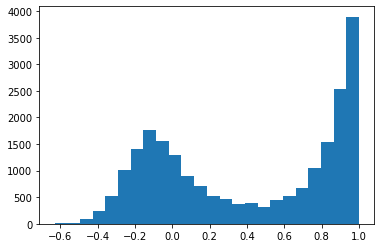

AUC score is 0.9368853323765914  while binary score is 0.8125224577793748 and the confusion matrix is [[ 6976  4156]
 [   18 11114]] on dev loader after 90000 iterations and 4 epoch
Model is saved after 90000 iterations 
OCloss is 0.06891945733541732 and BCEloss is 0.5268175436455526 and MNRloss is 0.0 and Cosloss is 0.1330927689915155  and time taken is 217794.74751877785 after 90000 iterations
OCloss is 0.06884997829598412 and BCEloss is 0.5268020775454846 and MNRloss is 0.0 and Cosloss is 0.13307252819648677  and time taken is 218033.4905025959 after 90500 iterations
OCloss is 0.06881482782952984 and BCEloss is 0.5267998511942584 and MNRloss is 0.0 and Cosloss is 0.13306296377915142  and time taken is 218274.231518507 after 91000 iterations
OCloss is 0.06882037568068168 and BCEloss is 0.5267852897597844 and MNRloss is 0.0 and Cosloss is 0.13304727968197194  and time taken is 218513.72219347954 after 91500 iterations
OCloss is 0.06885077912388696 and BCEloss is 0.5267912957983454 and

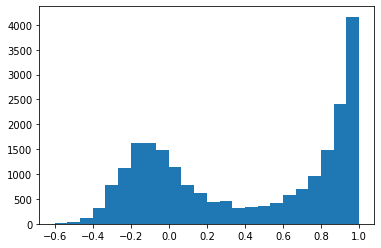

AUC score is 0.9344331250355828  while binary score is 0.8181818181818182 and the confusion matrix is [[ 7106  4026]
 [   22 11110]] on dev loader after 100000 iterations and 4 epoch
Model is saved after 100000 iterations 
OCloss is 0.06902809664718647 and BCEloss is 0.5266871888359002 and MNRloss is 0.0 and Cosloss is 0.1329178222647152  and time taken is 222845.55254149437 after 100000 iterations
OCloss is 0.06908552413130797 and BCEloss is 0.5266683928552034 and MNRloss is 0.0 and Cosloss is 0.13293835475264482  and time taken is 223081.67739915848 after 100500 iterations
OCloss is 0.06907541623600294 and BCEloss is 0.5266620995320879 and MNRloss is 0.0 and Cosloss is 0.13293001974940102  and time taken is 223320.35429048538 after 101000 iterations
OCloss is 0.06906653312949884 and BCEloss is 0.5266567666751808 and MNRloss is 0.0 and Cosloss is 0.13293968717832377  and time taken is 223558.9175069332 after 101500 iterations
OCloss is 0.0690979343896297 and BCEloss is 0.5266622782675

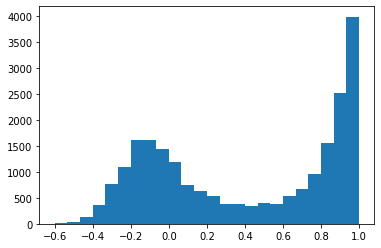

AUC score is 0.9360083167473889  while binary score is 0.8162055335968379 and the confusion matrix is [[ 7062  4070]
 [   22 11110]] on dev loader after 110000 iterations and 4 epoch
Model is saved after 110000 iterations 
OCloss is 0.06885940893175278 and BCEloss is 0.5266625998739778 and MNRloss is 0.0 and Cosloss is 0.13275623011055715  and time taken is 227858.5903582573 after 110000 iterations
OCloss is 0.06883641554008524 and BCEloss is 0.5266492675267639 and MNRloss is 0.0 and Cosloss is 0.1327593214850243  and time taken is 228094.18898296356 after 110500 iterations
OCloss is 0.06878410752055136 and BCEloss is 0.5266451928636211 and MNRloss is 0.0 and Cosloss is 0.13274176371103644  and time taken is 228329.95589113235 after 111000 iterations
OCloss is 0.06888404803855862 and BCEloss is 0.5266397098040017 and MNRloss is 0.0 and Cosloss is 0.13276059167218113  and time taken is 228566.36028528214 after 111500 iterations
OCloss is 0.06892113701320539 and BCEloss is 0.526647820348

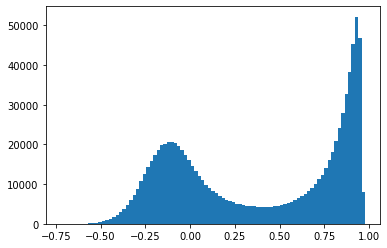

AUC and Bin_acc after training 4 on train dataloader is (0.9470597376032275, 0.8255901627945381) and confusion matrix is [[300095 160117]
 [   414 459798]]
Epoch 4/4
----------
OCloss is 0.0 and BCEloss is 0.5084587335586548 and MNRloss is 0.0 and Cosloss is 0.05887367203831673  and time taken is 230239.43801927567 after 0 iterations
OCloss is 0.07135836742788149 and BCEloss is 0.5244123720956182 and MNRloss is 0.0 and Cosloss is 0.12783218204543856  and time taken is 230472.082955122 after 500 iterations
OCloss is 0.06602470408023448 and BCEloss is 0.5241039498047634 and MNRloss is 0.0 and Cosloss is 0.12854134472092607  and time taken is 230707.11830449104 after 1000 iterations
OCloss is 0.06418863534224882 and BCEloss is 0.526185852996037 and MNRloss is 0.0 and Cosloss is 0.13016414194976506  and time taken is 230941.85485482216 after 1500 iterations
OCloss is 0.06043831606522285 and BCEloss is 0.5253159903336143 and MNRloss is 0.0 and Cosloss is 0.1297575923866001  and time taken i

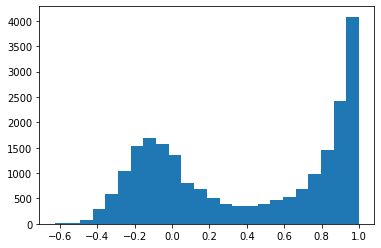

AUC score is 0.9357081761828823  while binary score is 0.8195292849443047 and the confusion matrix is [[ 7136  3996]
 [   22 11110]] on dev loader after 10000 iterations and 5 epoch
Model is saved after 10000 iterations 
OCloss is 0.06038438561271966 and BCEloss is 0.5251935821046305 and MNRloss is 0.0 and Cosloss is 0.1287821229351611  and time taken is 235171.34389281273 after 10000 iterations
OCloss is 0.06021478703230431 and BCEloss is 0.5252112130666503 and MNRloss is 0.0 and Cosloss is 0.1284399201093337  and time taken is 235405.03311634064 after 10500 iterations
OCloss is 0.06005228548455747 and BCEloss is 0.5250683491549246 and MNRloss is 0.0 and Cosloss is 0.12828781060821468  and time taken is 235636.76989912987 after 11000 iterations
OCloss is 0.05999036150880899 and BCEloss is 0.5250197655583929 and MNRloss is 0.0 and Cosloss is 0.12807098301083825  and time taken is 235869.1686770916 after 11500 iterations
OCloss is 0.06044657425544342 and BCEloss is 0.525174487594187 and

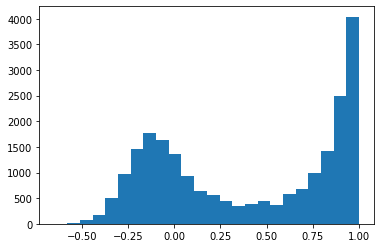

AUC score is 0.9358167313241812  while binary score is 0.8221343873517787 and the confusion matrix is [[ 7190  3942]
 [   18 11114]] on dev loader after 20000 iterations and 5 epoch
Model is saved after 20000 iterations 
OCloss is 0.061568336468219936 and BCEloss is 0.5247858173668036 and MNRloss is 0.0 and Cosloss is 0.12799547267035633  and time taken is 240091.01448249817 after 20000 iterations
OCloss is 0.06112411834708583 and BCEloss is 0.5248093816206099 and MNRloss is 0.0 and Cosloss is 0.12783755838670574  and time taken is 240321.1987748146 after 20500 iterations
OCloss is 0.06108141720256302 and BCEloss is 0.5247342073061961 and MNRloss is 0.0 and Cosloss is 0.12774804084883765  and time taken is 240551.82780694962 after 21000 iterations
OCloss is 0.06170310062285557 and BCEloss is 0.524806814172158 and MNRloss is 0.0 and Cosloss is 0.1279347132983505  and time taken is 240785.8556652069 after 21500 iterations
OCloss is 0.06173507396613256 and BCEloss is 0.5247335532289609 an

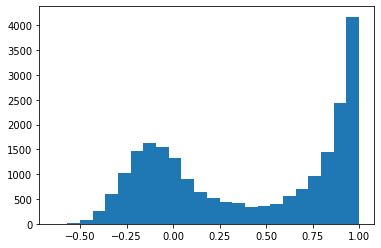

AUC score is 0.9366289581728036  while binary score is 0.8198886094143011 and the confusion matrix is [[ 7146  3986]
 [   24 11108]] on dev loader after 30000 iterations and 5 epoch
Model is saved after 30000 iterations 
OCloss is 0.06220011852704077 and BCEloss is 0.5247427572258663 and MNRloss is 0.0 and Cosloss is 0.1282946960223554  and time taken is 245004.4825773239 after 30000 iterations
OCloss is 0.06238367579652901 and BCEloss is 0.5247362296579939 and MNRloss is 0.0 and Cosloss is 0.12837275373035698  and time taken is 245237.90620994568 after 30500 iterations
OCloss is 0.06233897908386341 and BCEloss is 0.524684296717994 and MNRloss is 0.0 and Cosloss is 0.12834952784761844  and time taken is 245470.9861729145 after 31000 iterations
OCloss is 0.06240972413723337 and BCEloss is 0.5246628418028845 and MNRloss is 0.0 and Cosloss is 0.12832377715436757  and time taken is 245705.21340584755 after 31500 iterations
OCloss is 0.062380716955509855 and BCEloss is 0.5247208733140839 an

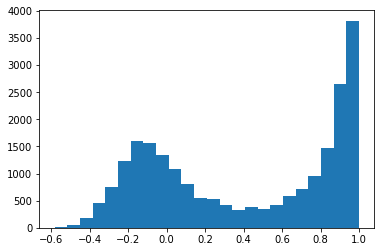

AUC score is 0.9404375254220233  while binary score is 0.8127919511318721 and the confusion matrix is [[ 6984  4148]
 [   20 11112]] on dev loader after 40000 iterations and 5 epoch
Model is saved after 40000 iterations 
OCloss is 0.06271786222121509 and BCEloss is 0.5246851305130622 and MNRloss is 0.0 and Cosloss is 0.1284239121421725  and time taken is 250002.4355905056 after 40000 iterations
OCloss is 0.06278103888868923 and BCEloss is 0.5247113118208249 and MNRloss is 0.0 and Cosloss is 0.12841829512381694  and time taken is 250239.33477258682 after 40500 iterations
OCloss is 0.06251073650804449 and BCEloss is 0.5246957340914081 and MNRloss is 0.0 and Cosloss is 0.12834868140015468  and time taken is 250477.82302331924 after 41000 iterations
OCloss is 0.06252657221758437 and BCEloss is 0.5247015668993636 and MNRloss is 0.0 and Cosloss is 0.12830848187446925  and time taken is 250717.44270515442 after 41500 iterations
OCloss is 0.06264198564173766 and BCEloss is 0.5247605431576842 a

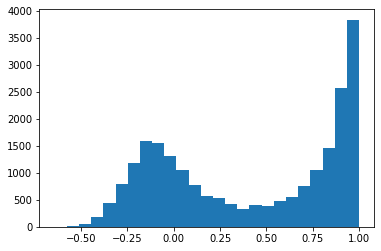

AUC score is 0.9374404897917927  while binary score is 0.8064139417894358 and the confusion matrix is [[ 6836  4296]
 [   14 11118]] on dev loader after 50000 iterations and 5 epoch
Model is saved after 50000 iterations 
OCloss is 0.06248813167721743 and BCEloss is 0.5245846477717806 and MNRloss is 0.0 and Cosloss is 0.12834741594971377  and time taken is 255068.00394153595 after 50000 iterations
OCloss is 0.06257583244059818 and BCEloss is 0.5245240897141467 and MNRloss is 0.0 and Cosloss is 0.12837237291645293  and time taken is 255308.44965434074 after 50500 iterations
OCloss is 0.06264016879094589 and BCEloss is 0.5245253714750155 and MNRloss is 0.0 and Cosloss is 0.12842654259338593  and time taken is 255549.9747312069 after 51000 iterations
OCloss is 0.06251309656226116 and BCEloss is 0.5244512700730858 and MNRloss is 0.0 and Cosloss is 0.12840911571211322  and time taken is 255790.23170518875 after 51500 iterations
OCloss is 0.0625450314299098 and BCEloss is 0.5244581367511666 a

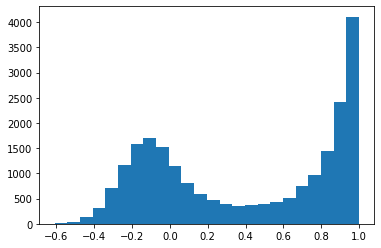

AUC score is 0.9362151972225272  while binary score is 0.8230326985267696 and the confusion matrix is [[ 7218  3914]
 [   26 11106]] on dev loader after 60000 iterations and 5 epoch
Model is saved after 60000 iterations 
OCloss is 0.06270679977670601 and BCEloss is 0.5246236650724733 and MNRloss is 0.0 and Cosloss is 0.1282976522509161  and time taken is 260177.92786359787 after 60000 iterations
OCloss is 0.06287880769472898 and BCEloss is 0.5246020350346331 and MNRloss is 0.0 and Cosloss is 0.12831756560146046  and time taken is 260416.8683309555 after 60500 iterations
OCloss is 0.06277322798826747 and BCEloss is 0.5245704602042983 and MNRloss is 0.0 and Cosloss is 0.12828118248682738  and time taken is 260658.94341421127 after 61000 iterations
OCloss is 0.06270325987448663 and BCEloss is 0.5245798010829678 and MNRloss is 0.0 and Cosloss is 0.12826897810026422  and time taken is 260900.0638487339 after 61500 iterations
OCloss is 0.06269961933698431 and BCEloss is 0.5245794302581678 an

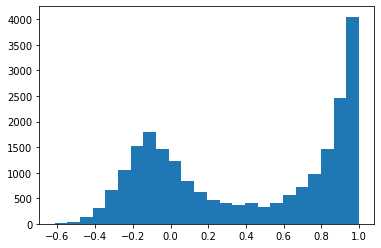

AUC score is 0.936694409076844  while binary score is 0.8190801293568092 and the confusion matrix is [[ 7126  4006]
 [   22 11110]] on dev loader after 70000 iterations and 5 epoch
Model is saved after 70000 iterations 
OCloss is 0.0627738711264482 and BCEloss is 0.5246690301651209 and MNRloss is 0.0 and Cosloss is 0.1281995037136614  and time taken is 265306.97804427147 after 70000 iterations
OCloss is 0.06275340580824311 and BCEloss is 0.5246591546447025 and MNRloss is 0.0 and Cosloss is 0.1281859648336329  and time taken is 265548.23748874664 after 70500 iterations
OCloss is 0.06273918904543237 and BCEloss is 0.5246959238229937 and MNRloss is 0.0 and Cosloss is 0.12818352965202717  and time taken is 265791.4415178299 after 71000 iterations
OCloss is 0.06272655589734365 and BCEloss is 0.5246934127672404 and MNRloss is 0.0 and Cosloss is 0.1281757386949096  and time taken is 266034.913248539 after 71500 iterations
OCloss is 0.06264869289141332 and BCEloss is 0.5246387495914897 and MNR

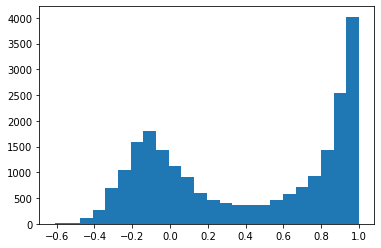

AUC score is 0.9354053209121886  while binary score is 0.8179123248293209 and the confusion matrix is [[ 7094  4038]
 [   16 11116]] on dev loader after 80000 iterations and 5 epoch
Model is saved after 80000 iterations 
OCloss is 0.06275621008234805 and BCEloss is 0.5246187974565606 and MNRloss is 0.0 and Cosloss is 0.12814935724237553  and time taken is 270453.441562891 after 80000 iterations
OCloss is 0.06272450581321704 and BCEloss is 0.5245951970383 and MNRloss is 0.0 and Cosloss is 0.12813334022313838  and time taken is 270698.35692954063 after 80500 iterations
OCloss is 0.0626476166656808 and BCEloss is 0.5245882760431161 and MNRloss is 0.0 and Cosloss is 0.12810484244388004  and time taken is 270941.0493261814 after 81000 iterations
OCloss is 0.06262997115565551 and BCEloss is 0.5245785994559182 and MNRloss is 0.0 and Cosloss is 0.12807575036936436  and time taken is 271184.750834465 after 81500 iterations
OCloss is 0.06258253987121608 and BCEloss is 0.5245804520786871 and MNRl

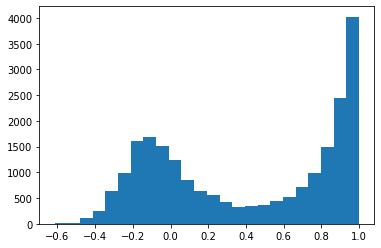

AUC score is 0.9388663726633244  while binary score is 0.8135106000718649 and the confusion matrix is [[ 6998  4134]
 [   18 11114]] on dev loader after 90000 iterations and 5 epoch
Model is saved after 90000 iterations 
OCloss is 0.062471137113018105 and BCEloss is 0.5244882499912318 and MNRloss is 0.0 and Cosloss is 0.12803394185765954  and time taken is 275622.91829395294 after 90000 iterations
OCloss is 0.06248061833888036 and BCEloss is 0.524488244578938 and MNRloss is 0.0 and Cosloss is 0.12802782441322022  and time taken is 275865.7712416649 after 90500 iterations
OCloss is 0.06251088094108745 and BCEloss is 0.5244965960234844 and MNRloss is 0.0 and Cosloss is 0.12802724591887737  and time taken is 276110.3559396267 after 91000 iterations
OCloss is 0.06246239035431857 and BCEloss is 0.5244879534800294 and MNRloss is 0.0 and Cosloss is 0.12800915381719255  and time taken is 276356.13133621216 after 91500 iterations
OCloss is 0.062455891183606504 and BCEloss is 0.524501984141715 a

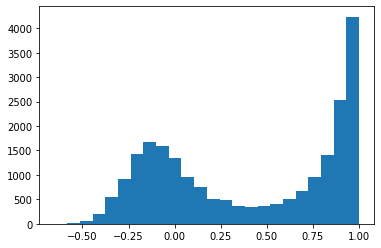

AUC score is 0.9337231962615609  while binary score is 0.8183614804168163 and the confusion matrix is [[ 7122  4010]
 [   34 11098]] on dev loader after 100000 iterations and 5 epoch
Model is saved after 100000 iterations 
OCloss is 0.06268587851741145 and BCEloss is 0.5244164225303563 and MNRloss is 0.0 and Cosloss is 0.12795878361004034  and time taken is 280815.58456754684 after 100000 iterations
OCloss is 0.06263088734842315 and BCEloss is 0.5244061163704277 and MNRloss is 0.0 and Cosloss is 0.12793081529486083  and time taken is 281058.1816263199 after 100500 iterations
OCloss is 0.06270879124133459 and BCEloss is 0.524389512152593 and MNRloss is 0.0 and Cosloss is 0.1279486485831901  and time taken is 281303.13149929047 after 101000 iterations
OCloss is 0.06268330168627341 and BCEloss is 0.5244081594932467 and MNRloss is 0.0 and Cosloss is 0.12796019982205195  and time taken is 281547.5082781315 after 101500 iterations
OCloss is 0.06265802980899118 and BCEloss is 0.52439802631533

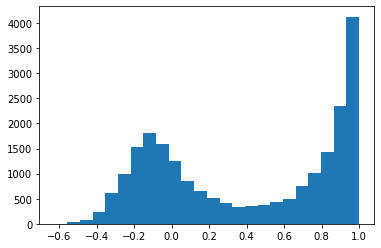

AUC score is 0.9356514322023435  while binary score is 0.8220445562342795 and the confusion matrix is [[ 7184  3948]
 [   14 11118]] on dev loader after 110000 iterations and 5 epoch
Model is saved after 110000 iterations 
OCloss is 0.06250542459299228 and BCEloss is 0.5243643628910569 and MNRloss is 0.0 and Cosloss is 0.1278646669255199  and time taken is 285973.0794286728 after 110000 iterations
OCloss is 0.06251077583576421 and BCEloss is 0.5243575820596965 and MNRloss is 0.0 and Cosloss is 0.1278439845518892  and time taken is 286215.02350497246 after 110500 iterations
OCloss is 0.06254668268835771 and BCEloss is 0.5243721855049625 and MNRloss is 0.0 and Cosloss is 0.12783631025371658  and time taken is 286459.33232450485 after 111000 iterations
OCloss is 0.06253687692129299 and BCEloss is 0.5243727286094334 and MNRloss is 0.0 and Cosloss is 0.1278367033463764  and time taken is 286702.7369828224 after 111500 iterations
OCloss is 0.06253628677078489 and BCEloss is 0.524393209236732

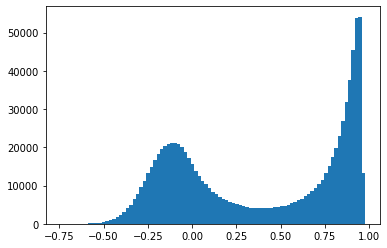

AUC and Bin_acc after training 5 on train dataloader is (0.9518649411062818, 0.8307377904096372) and confusion matrix is [[304734 155478]
 [   315 459897]]
    0 iterations have been done in 0.4365065097808838 seconds
    1000 iterations have been done in 224.45696997642517 seconds
    2000 iterations have been done in 456.9755914211273 seconds


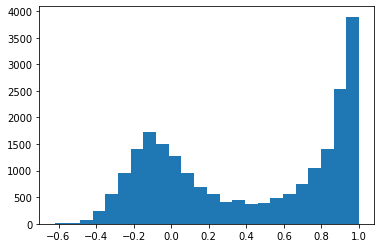

AUC and Bin_acc after training 5 on dev dataloader is (0.9364602491151457, 0.8009342436219906) and the confusion matris is [[ 6712  4420]
 [   12 11120]]
Model is saved after 5 epochs 


In [39]:
#Overall parameters in model
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
train_model(train_loader,model,5)

    0 iterations have been done in 0.5238373279571533 seconds
    1000 iterations have been done in 181.07039833068848 seconds
    2000 iterations have been done in 409.48325085639954 seconds


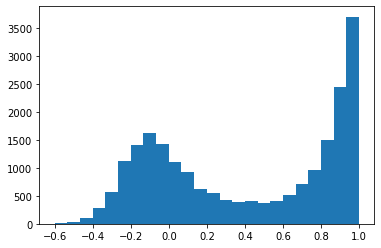

AUC and Bin_acc after testing  is (0.9277118604387218, 0.8030162842339008) and the confusion matris is [[ 6586  4222]
 [   36 10772]]


In [40]:
a,b,c = AUC_evaluator.cal(model,test_loader)
print(f'AUC and Bin_acc after testing  is {a,b} and the confusion matris is {c}')

# Evaluator

## Binary Classification Evaluator

In [ ]:
# from . import SentenceEvaluator
import logging
import os
import csv
from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances, paired_manhattan_distances
from sklearn.metrics import average_precision_score
import numpy as np
from typing import List
# from ..readers import InputExample


logger = logging.getLogger(__name__)


In [ ]:
class BinaryClassificationEvaluator():
    """
    Evaluate a model based on the similarity of the embeddings by calculating the accuracy of identifying similar and
    dissimilar sentences.
    The metrics are the cosine similarity as well as euclidean and Manhattan distance
    The returned score is the accuracy with a specified metric.
    The results are written in a CSV. If a CSV already exists, then values are appended.
    The labels need to be 0 for dissimilar pairs and 1 for similar pairs.
    :param sentences1: The first column of sentences
    :param sentences2: The second column of sentences
    :param labels: labels[i] is the label for the pair (sentences1[i], sentences2[i]). Must be 0 or 1
    :param name: Name for the output
    :param batch_size: Batch size used to compute embeddings
    :param show_progress_bar: If true, prints a progress bar
    :param write_csv: Write results to a CSV file
    """

    def __init__(self,
                 dataset,
                 name: str = '',
                 batch_size: int = 32,
                 show_progress_bar: bool = False,
                 write_csv: bool = True
                 ):
        
        self.dataset = dataset
        self.labels = list()
        self.write_csv = write_csv
        self.name = name
        self.batch_size = batch_size
        self.dataloader = DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers = 8,
            shuffle = True
        )

        if show_progress_bar is None:
            show_progress_bar = (logger.getEffectiveLevel() == logging.INFO or logger.getEffectiveLevel() == logging.DEBUG)
        self.show_progress_bar = show_progress_bar

        self.csv_file = "binary_classification_evaluation" + ("_"+name if name else '') + "_results.csv"
        self.csv_headers = ["epoch", "steps",
                            "cosine_acc", "cosine_acc_threshold", "cosine_f1", "cosine_precision", "cosine_recall", "cosine_f1_threshold", "cosine_average_precision",
                            "manhatten_acc", "manhatten_acc_threshold", "manhatten_f1", "manhatten_precision", "manhatten_recall", "manhatten_f1_threshold", "manhatten_average_precision",
                            "eucledian_acc", "eucledian_acc_threshold", "eucledian_f1", "eucledian_precision", "eucledian_recall", "eucledian_f1_threshold", "eucledian_average_precision"]


    # @classmethod
    # def from_input_examples(cls, examples: List[InputExample], **kwargs):
    #     sentences1 = []
    #     sentences2 = []
    #     scores = []

    #     for example in examples:
    #         sentences1.append(example.texts[0])
    #         sentences2.append(example.texts[1])
    #         scores.append(example.label)
    #     return cls(sentences1, sentences2, scores, **kwargs)

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:

        if epoch != -1:
            if steps == -1:
                out_txt = f" after epoch {epoch}:"
            else:
                out_txt = f" in epoch {epoch} after {steps} steps:"
        else:
            out_txt = ":"

        logger.info("Binary Accuracy Evaluation of the model on " + self.name + " dataset" + out_txt)
        
        embeddings1 = list()
        embeddings2 = list()

        with torch.no_grad():
            model.eval()
            for i, batch in enumerate(self.dataloader):
                images = batch["image"]
                label = batch["label"]
                label = label.float()
                token = batch["token"]
                
                # print(images,label,token)

                images[0],images[1] = images[0].to(device),images[1].to(device)
                token[0],token[1] = token[0].to(device), token[1].to(device)
                label = label.to(device)
                
                # compute the model output
                yhat1 = model(images[0], token[0])
                yhat2 = model(images[1],token[1])

                for j in yhat1:
                    embeddings1.append(j.cpu().detach().numpy())
                for j in yhat2:
                    embeddings2.append(j.cpu().detach().numpy())
                for j in label:
                    self.labels.append(float(j))
                
                if(i%30==0 and i!=0):
                    print(f'Completed {i} iterations')

        cosine_scores = 1-paired_cosine_distances(embeddings1, embeddings2)
        manhattan_distances = paired_manhattan_distances(embeddings1, embeddings2)
        euclidean_distances = paired_euclidean_distances(embeddings1, embeddings2)


        labels = np.asarray(self.labels)

        file_output_data = [epoch, steps]

        main_score = None
        for name, scores, reverse in [['Cosine-Similarity', cosine_scores, True], ['Manhatten-Distance', manhattan_distances, False], ['Euclidean-Distance', euclidean_distances, False]]:
            acc, acc_threshold = self.find_best_acc_and_threshold(scores, labels, reverse)
            f1, precision, recall, f1_threshold = self.find_best_f1_and_threshold(scores, labels, reverse)
            ap = average_precision_score(labels, scores * (1 if reverse else -1))

            logger.info("Accuracy with {}:           {:.2f}\t(Threshold: {:.4f})".format(name, acc * 100, acc_threshold))
            logger.info("F1 with {}:                 {:.2f}\t(Threshold: {:.4f})".format(name, f1 * 100, f1_threshold))
            logger.info("Precision with {}:          {:.2f}".format(name, precision * 100))
            logger.info("Recall with {}:             {:.2f}".format(name, recall * 100))
            logger.info("Average Precision with {}:  {:.2f}\n".format(name, ap * 100))

            file_output_data.extend([acc, acc_threshold, f1, precision, recall, f1_threshold, ap])

            if main_score is None: #Use AveragePrecision with Cosine-Similarity as main score
                main_score = ap

        if output_path is not None and self.write_csv:
            csv_path = os.path.join(output_path, self.csv_file)
            if not os.path.isfile(csv_path):
                with open(csv_path, mode="w", encoding="utf-8") as f:
                    writer = csv.writer(f)
                    writer.writerow(self.csv_headers)
                    writer.writerow(file_output_data)
            else:
                with open(csv_path, mode="a", encoding="utf-8") as f:
                    writer = csv.writer(f)
                    writer.writerow(file_output_data)

        return main_score

    @staticmethod
    def find_best_acc_and_threshold(scores, labels, high_score_more_similar: bool):
        # assert len(scores) == len(labels)
        rows = list(zip(scores, labels))

        rows = sorted(rows, key=lambda x: x[0], reverse=high_score_more_similar)

        max_acc = 0
        best_threshold = -1

        positive_so_far = 0
        remaining_negatives = sum(labels == 0)

        for i in range(len(rows)-1):
            score, label = rows[i]
            if label == 1:
                positive_so_far += 1
            else:
                remaining_negatives -= 1

            acc = (positive_so_far + remaining_negatives) / len(labels)
            if acc > max_acc:
                max_acc = acc
                best_threshold = (rows[i][0] + rows[i+1][0]) / 2

        return max_acc, best_threshold

    @staticmethod
    def find_best_f1_and_threshold(scores, labels, high_score_more_similar: bool):
        # assert len(scores) == len(labels)

        scores = np.asarray(scores)
        labels = np.asarray(labels)

        rows = list(zip(scores, labels))

        rows = sorted(rows, key=lambda x: x[0], reverse=high_score_more_similar)

        best_f1 = best_precision = best_recall = 0
        threshold = 0
        nextract = 0
        ncorrect = 0
        total_num_duplicates = sum(labels)

        for i in range(len(rows)-1):
            score, label = rows[i]
            nextract += 1

            if label == 1:
                ncorrect += 1

            if ncorrect > 0:
                precision = ncorrect / nextract
                recall = ncorrect / total_num_duplicates
                f1 = 2 * precision * recall / (precision + recall)
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

        return best_f1, best_precision, best_recall, threshold

In [ ]:
dev_BCEvaluator = BinaryClassificationEvaluator(dev_dataset,batch_size=BATCH_SIZE,show_progress_bar=True)
os.makedirs(folder+'/dev',exist_ok = True)
dev_BCEvaluator(model,output_path=folder+'/dev')

In [ ]:
train_BCEvaluator = BinaryClassificationEvaluator(train_dataset,batch_size=BATCH_SIZE,show_progress_bar=True)
os.makedirs(folder+'/train',exist_ok = True)
train_BCEvaluator(model,output_path=folder+'/train')

## Information retreival evaluator

In [ ]:
import torch
import logging
from tqdm import tqdm, trange
import os
import numpy as np
from typing import List, Tuple, Dict, Set

In [ ]:
class infodataset(Dataset):
    def __init__(self,qr,qr_idx,img_dir,transform = None):
        self.qr = qr
        self.qr_idx = qr_idx
        self.img_dir = img_dir
        self.transform = transform

    def image_adder(self,id1):
        img_id1 = list()
        if((self.qr.at[id1,'Attachments'])!=None):
            for i in self.qr.at[id1,'Attachments']:
                try:
                    img_path = os.path.join(self.img_dir,i)
                    img = Image.open(img_path).convert('RGB')
                    if(self.transform):
                        img = self.transform(img)
                        img.reshape(3,224,224)
                    img_id1.append(img)
                except Exception as e: 
                    print(e)
        else:
            img_id1.append(torch.zeros(3,224,224))

        # Work on this, for few examples, it is still saying list index out of range
        if(len(img_id1)==0):
            # print('No attachments found for id {}'.format(id1))
            print(f'Something went wrong with the image of id {id1}')
            img_id1.append(torch.zeros(3,224,224))

        return img_id1
    
    def __getitem__(self,idx):
        id1 = self.qr_idx[idx]
        img_id1 = self.image_adder(id1)

        # print(len(img_id1))

        # print('Printing id1 {} and len {} and id2 {} and len {} '.format(
        #     id1,len(img_id1),
        #     id2, len(img_id2)
        # ))

        # print('Printing id1 shape {} and id2  shape {}'.format(
        #     img_id1[0].shape,
        #     img_id2[0].shape
        # ))        

        sample = {
            'image': img_id1[0]    #Currently taking only one input image
        }

        t1 = '[CLS]' + self.qr.loc[id1,'Title'] + ' ' + ' '.join(self.qr.loc[id1,'Tags']) + ' ' + self.qr.loc[id1,'Text'] + '[SEP]'
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        t1_token = tokenizer.tokenize(t1)
        indexed_t1 = tokenizer.convert_tokens_to_ids(t1_token)
        
        while(len(indexed_t1)<512):
            indexed_t1.append(0)
        
        ten_t1 = torch.tensor(indexed_t1)[:512]
        
        try:
            sample["token"] = ten_t1 # torch.Size([batch_size, 512])
        except Exception as e:
            print(e)
        
        return sample

    def __len__(self):
        return len(self.qr_idx)

In [ ]:
class InformationRetreivalEvaluator():
    def __init__(self,
                 qr,
                 queries: Dict[str, str],  #qid => query
                 corpus: Dict[str, str],  #cid => doc
                 relevant_docs: Dict[str, Set[str]],  #qid => Set[cid]
                 corpus_chunk_size: int = 50000,
                 mrr_at_k: List[int] = [10],
                 ndcg_at_k: List[int] = [10],
                 accuracy_at_k: List[int] = [1, 3, 5, 10],
                 precision_recall_at_k: List[int] = [1, 3, 5, 10],
                 map_at_k: List[int] = [100],
                 show_progress_bar: bool = False,
                 batch_size: int = 32,
                 name: str = '',
                 write_csv: bool = True
                 ):
        
        self.qr = qr
        self.queries_ids = []
        for qid in queries:
            if qid in relevant_docs and len(relevant_docs[qid]) > 0:
                self.queries_ids.append(qid)

        self.queries = [queries[qid] for qid in self.queries_ids]

        self.corpus_ids = list(corpus.keys())
        self.corpus = [corpus[cid] for cid in self.corpus_ids]

        self.relevant_docs = relevant_docs
        self.corpus_chunk_size = corpus_chunk_size
        self.mrr_at_k = mrr_at_k
        self.ndcg_at_k = ndcg_at_k
        self.accuracy_at_k = accuracy_at_k
        self.precision_recall_at_k = precision_recall_at_k
        self.map_at_k = map_at_k

        self.show_progress_bar = show_progress_bar
        self.batch_size = batch_size
        self.name = name
        self.write_csv = write_csv

        if name:
            name = "_" + name

        self.csv_file: str = "Information-Retrieval_evaluation" + name + "_results.csv"
        self.csv_headers = ["epoch", "steps"]


        for k in accuracy_at_k:
            self.csv_headers.append("Accuracy@{}".format(k))

        for k in precision_recall_at_k:
            self.csv_headers.append("Precision@{}".format(k))
            self.csv_headers.append("Recall@{}".format(k))

        for k in mrr_at_k:
            self.csv_headers.append("MRR@{}".format(k))

        for k in ndcg_at_k:
            self.csv_headers.append("NDCG@{}".format(k))

        for k in map_at_k:
            self.csv_headers.append("MAP@{}".format(k))
    
    def __call__(self,model : BridgeModel,output_path: str = None,epoch: int = -1, steps: int = -1) ->float:
        if epoch != -1:
            out_txt = " after epoch {}:".format(epoch) if steps == -1 else " in epoch {} after {} steps:".format(epoch, steps)
        else:
            out_txt = ":"

        logger.info("Information Retrieval Evaluation on " + self.name + " dataset" + out_txt)

        max_k = max(max(self.mrr_at_k), max(self.ndcg_at_k), max(self.accuracy_at_k), max(self.precision_recall_at_k), max(self.map_at_k))

        query_embeddings = self.get_embeddings(model,self.qr,self.queries_ids)

        queries_result_list = [[] for _ in range(len(query_embeddings))]

        itr = range(0, len(self.corpus), self.corpus_chunk_size)

        if self.show_progress_bar:
            itr = tqdm(itr, desc='Corpus Chunks')

        #Iterate over chunks of the corpus
        for corpus_start_idx in itr:
            corpus_end_idx = min(corpus_start_idx + self.corpus_chunk_size, len(self.corpus))

            #Encode chunk of corpus
            sub_corpus_embeddings = self.get_embeddings(model,self.qr,self.corpus_ids[corpus_start_idx:corpus_end_idx])

            #Compute cosine similarites
            cos_scores = pytorch_cos_sim(query_embeddings, sub_corpus_embeddings)
            del sub_corpus_embeddings

            #Get top-k values
            cos_scores_top_k_values, cos_scores_top_k_idx = torch.topk(cos_scores, min(max_k, len(cos_scores[0])), dim=1, largest=True, sorted=False)
            cos_scores_top_k_values = cos_scores_top_k_values.cpu().tolist()
            cos_scores_top_k_idx = cos_scores_top_k_idx.cpu().tolist()
            del cos_scores

            for query_itr in range(len(query_embeddings)):
                for sub_corpus_id, score in zip(cos_scores_top_k_idx[query_itr], cos_scores_top_k_values[query_itr]):
                    corpus_id = self.corpus_ids[corpus_start_idx+sub_corpus_id]
                    queries_result_list[query_itr].append({'corpus_id': corpus_id, 'score': score})


        #Compute scores
        scores = self.compute_metrics(queries_result_list)

        #Output
        self.output_scores(scores)


        # logger.info("Queries: {}".format(len(self.queries)))
        # logger.info("Corpus: {}\n".format(len(self.corpus)))

        if output_path is not None and self.write_csv:
            csv_path = os.path.join(output_path, self.csv_file)
            if not os.path.isfile(csv_path):
                fOut = open(csv_path, mode="w", encoding="utf-8")
                fOut.write(",".join(self.csv_headers))
                fOut.write("\n")

            else:
                fOut = open(csv_path, mode="a", encoding="utf-8")

            output_data = [epoch, steps]
            for k in self.accuracy_at_k:
                output_data.append(scores['accuracy@k'][k])

            for k in self.precision_recall_at_k:
                output_data.append(scores['precision@k'][k])
                output_data.append(scores['recall@k'][k])

            for k in self.mrr_at_k:
                output_data.append(scores['mrr@k'][k])

            for k in self.ndcg_at_k:
                output_data.append(scores['ndcg@k'][k])

            for k in self.map_at_k:
                output_data.append(scores['map@k'][k])

            fOut.write(",".join(map(str,output_data)))
            fOut.write("\n")
            fOut.close()

        return scores['map@k'][max(self.map_at_k)]


    def compute_metrics(self, queries_result_list: List[object]):
        # Init score computation values
        num_hits_at_k = {k: 0 for k in self.accuracy_at_k}
        precisions_at_k = {k: [] for k in self.precision_recall_at_k}
        recall_at_k = {k: [] for k in self.precision_recall_at_k}
        MRR = {k: 0 for k in self.mrr_at_k}
        ndcg = {k: [] for k in self.ndcg_at_k}
        AveP_at_k = {k: [] for k in self.map_at_k}

        # Compute scores on results
        for query_itr in range(len(queries_result_list)):
            query_id = self.queries_ids[query_itr]

            # Sort scores
            top_hits = sorted(queries_result_list[query_itr], key=lambda x: x['score'], reverse=True)
            query_relevant_docs = self.relevant_docs[query_id]

            # Accuracy@k - We count the result correct, if at least one relevant doc is accross the top-k documents
            for k_val in self.accuracy_at_k:
                for hit in top_hits[0:k_val]:
                    if hit['corpus_id'] in query_relevant_docs:
                        num_hits_at_k[k_val] += 1
                        break

            # Precision and Recall@k
            for k_val in self.precision_recall_at_k:
                num_correct = 0
                for hit in top_hits[0:k_val]:
                    if hit['corpus_id'] in query_relevant_docs:
                        num_correct += 1

                precisions_at_k[k_val].append(num_correct / k_val)
                recall_at_k[k_val].append(num_correct / len(query_relevant_docs))

            # MRR@k
            for k_val in self.mrr_at_k:
                for rank, hit in enumerate(top_hits[0:k_val]):
                    if hit['corpus_id'] in query_relevant_docs:
                        MRR[k_val] += 1.0 / (rank + 1)
                        break

            # NDCG@k
            for k_val in self.ndcg_at_k:
                predicted_relevance = [1 if top_hit['corpus_id'] in query_relevant_docs else 0 for top_hit in top_hits[0:k_val]]
                true_relevances = [1] * len(query_relevant_docs)

                ndcg_value = self.compute_dcg_at_k(predicted_relevance, k_val) / self.compute_dcg_at_k(true_relevances, k_val)
                ndcg[k_val].append(ndcg_value)

            # MAP@k
            for k_val in self.map_at_k:
                num_correct = 0
                sum_precisions = 0

                for rank, hit in enumerate(top_hits[0:k_val]):
                    if hit['corpus_id'] in query_relevant_docs:
                        num_correct += 1
                        sum_precisions += num_correct / (rank + 1)

                avg_precision = sum_precisions / min(k_val, len(query_relevant_docs))
                AveP_at_k[k_val].append(avg_precision)

        # Compute averages
        for k in num_hits_at_k:
            num_hits_at_k[k] /= len(self.queries_ids)

        for k in precisions_at_k:
            precisions_at_k[k] = np.mean(precisions_at_k[k])

        for k in recall_at_k:
            recall_at_k[k] = np.mean(recall_at_k[k])

        for k in ndcg:
            ndcg[k] = np.mean(ndcg[k])

        for k in MRR:
            MRR[k] /= len(self.queries_ids)

        for k in AveP_at_k:
            AveP_at_k[k] = np.mean(AveP_at_k[k])


        return {'accuracy@k': num_hits_at_k, 'precision@k': precisions_at_k, 'recall@k': recall_at_k, 'ndcg@k': ndcg, 'mrr@k': MRR, 'map@k': AveP_at_k}


    def output_scores(self, scores):
        for k in scores['accuracy@k']:
            logger.info("Accuracy@{}: {:.2f}%".format(k, scores['accuracy@k'][k]*100))

        for k in scores['precision@k']:
            logger.info("Precision@{}: {:.2f}%".format(k, scores['precision@k'][k]*100))

        for k in scores['recall@k']:
            logger.info("Recall@{}: {:.2f}%".format(k, scores['recall@k'][k]*100))

        for k in scores['mrr@k']:
            logger.info("MRR@{}: {:.4f}".format(k, scores['mrr@k'][k]))

        for k in scores['ndcg@k']:
            logger.info("NDCG@{}: {:.4f}".format(k, scores['ndcg@k'][k]))

        for k in scores['map@k']:
            logger.info("MAP@{}: {:.4f}".format(k, scores['map@k'][k]))


    @staticmethod
    def compute_dcg_at_k(relevances, k):
        dcg = 0
        for i in range(min(len(relevances), k)):
            dcg += relevances[i] / np.log2(i + 2)  #+2 as we start our idx at 0
        return dcg
    
    def get_embeddings(self,model,qr,qr_idx):
        info_dataset = infodataset(qr,qr_idx,img_dir,transform = transform_pipe)
        info_loader = DataLoader(
            info_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            num_workers = 8,
            )
        
        embeddings = list()
        since = time.time()
        for i,batch in enumerate(info_loader):
            model.eval()

            text = batch['token']
            images = batch['image']

            text,images = torch.tensor(text).to(device), torch.tensor(images).to(device)

            with torch.no_grad():
                yhat = model.forward(images,text)
            
            for j in yhat:
                embeddings.append(j.cpu().detach().numpy())
            
            if(i%40==0):
                print(f'{i} iterations hase been completed, and model is running for {time.time()-since}')
        
        return embeddings


In [ ]:
with open(folder_quora+'/devinfo_100.txt','rb') as a:
    queries_dev = pickle.load(a)
    rel_docs_dev= pickle.load(a)

with open(folder_quora+'/testinfo_100.txt','rb') as a:
    queries_test= pickle.load(a)
    rel_docs_test= pickle.load(a)

with open(folder_quora+'/traininfo_100.txt','rb') as a:
    queries_train= pickle.load(a)
    rel_docs_train= pickle.load(a)

In [ ]:
def corpus(qr):
    corpus = dict()
    for i in qr.index.values:
        corpus[i] = 'I dont care'
    return corpus

In [ ]:
train_inforet = InformationRetreivalEvaluator(train_qr,queries_train,corpus(train_qr),rel_docs_train)
os.makedirs(folder+'/train',exist_ok=True)
train_inforet(model,folder+'/train')

In [ ]:
dev_inforet = InformationRetreivalEvaluator(pd.concat([train_qr,dev_qr]),queries_dev,corpus(train_qr),rel_docs_dev)
os.makedirs(folder+'/dev',exist_ok=True)
dev_inforet(model,folder+'/dev')